**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [7]:
from IPython.core.interactiveshell import InteractiveShell # make all output in ipython show, not just last line
InteractiveShell.ast_node_interactivity = "all"   # pretty print all cell's output and not just the last one
%matplotlib inline
import sklearn
sklearn.set_config(display="diagram")

In [8]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [9]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [10]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [11]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

As discussed in Chapter 10, the backpropagation algorithm’s second phase works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a gradient descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem.

In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces most often in recurrent neural networks.

Text(3.5, 0.7, 'Saturating')

Text(-3.5, 0.3, 'Saturating')

Text(2, 0.2, 'Linear')

(-5.0, 5.0, -0.2, 1.2)

Text(0.5, 0, '$z$')

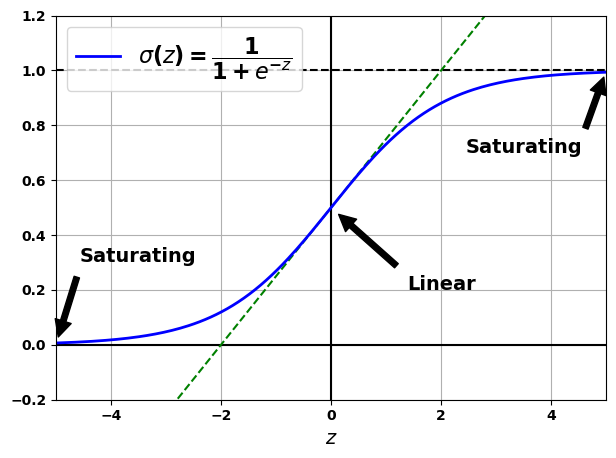

In [12]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

The authors found a few suspects, including the combination of the popular sigmoid (logistic) activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the sigmoid function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the sigmoid function in deep networks).

Looking at the sigmoid activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0 (i.e., the curve is flat at both extremes). Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

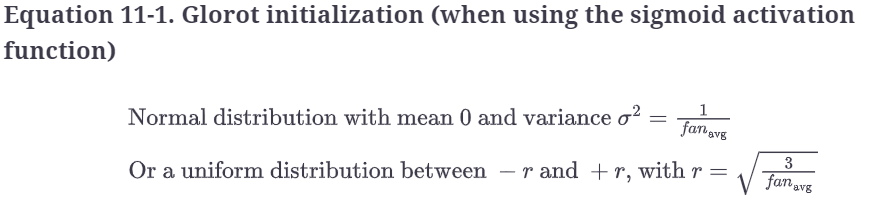

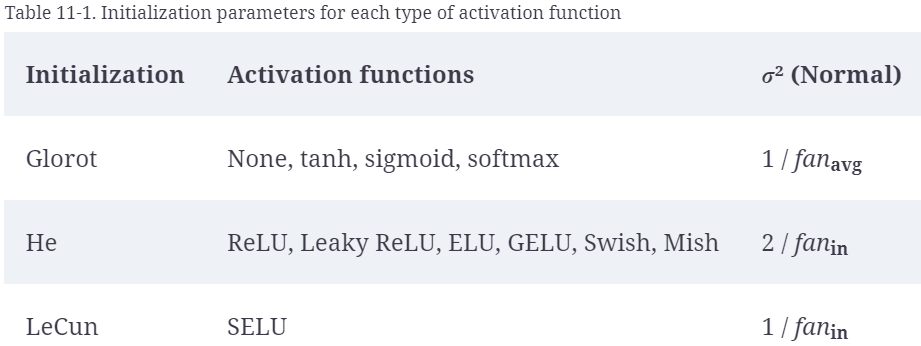

In [13]:
# By default, Keras uses Glorot initialization with a uniform distribution.
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")  # 

Alternatively, you can obtain any of the initializations listed in Table 11-1 and more using the VarianceScaling initializer. For example, if you want He initialization with a uniform distribution and based on fanavg (rather than fanin), you can use the following code:

In [14]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

 the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die”, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the input of the ReLU function (i.e., the weighted sum of the neuron’s inputs plus its bias term) is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.⁠4

### Leaky ReLU

The leaky ReLU activation function is defined as LeakyReLUα(z) = max(αz, z) (see Figure below). The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0. Having a slope for z < 0 ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.

Text(-3.5, 0.5, 'Leak')

Text(0.5, 0, '$z$')

(-5.0, 5.0, -1.0, 3.7)

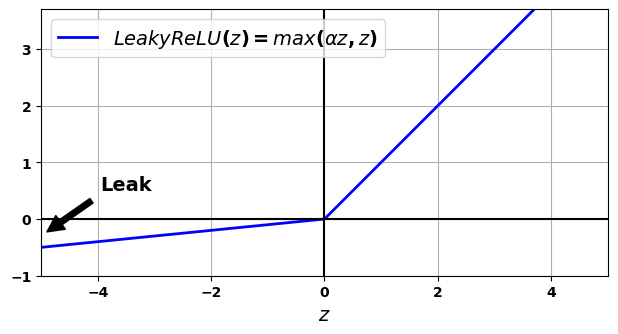

In [15]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [16]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [17]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

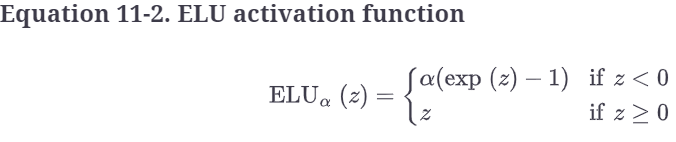

The ELU activation function looks a lot like the ReLU function (see Figure 11-3), with a few major differences:

It takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter α defines the opposite of the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.

It has a nonzero gradient for z < 0, which avoids the dead neurons problem.

If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up gradient descent since it does not bounce as much to the left and right of z = 0.

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [18]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

Not long after, a 2017 paper by Günter Klambauer et al.⁠7 introduced the scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function (about 1.05 times ELU, using α ≈ 1.67). The authors showed that if you build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. 

There a few conditions for self-normalization to happen (see the paper for the mathematical justification):

The input features must be standardized: mean 0 and standard deviation 1.

Every hidden layer’s weights must be initialized using LeCun normal initialization. In Keras, this means setting kernel_initializer="lecun_normal".

The self-normalizing property is only guaranteed with plain MLPs. If you try to use SELU in other architectures, like recurrent networks (see Chapter 15) or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), it will probably not outperform ELU.

You cannot use regularization techniques like ℓ1 or ℓ2 regularization, max-norm, batch-norm, or regular dropout (these are discussed later in this chapter).

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

(-5.0, 5.0, -2.2, 3.2)

Text(0.5, 0, '$z$')

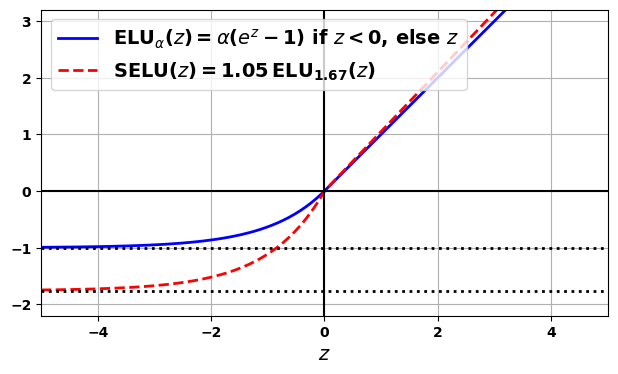

In [19]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [20]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers (100 neurons per layer), using the SELU activation function:

In [21]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [23]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [24]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [25]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [26]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 79s 44ms/step - loss: 1.1754 - accuracy: 0.5544 - val_loss: 0.7783 - val_accuracy: 0.7168
Epoch 2/5
1719/1719 [==============================] - 75s 44ms/step - loss: 0.7744 - accuracy: 0.7195 - val_loss: 0.9693 - val_accuracy: 0.6744
Epoch 3/5
1719/1719 [==============================] - 77s 45ms/step - loss: 0.7721 - accuracy: 0.7267 - val_loss: 0.6396 - val_accuracy: 0.7716
Epoch 4/5
1719/1719 [==============================] - 79s 46ms/step - loss: 0.6721 - accuracy: 0.7594 - val_loss: 0.8372 - val_accuracy: 0.6788
Epoch 5/5
1719/1719 [==============================] - 77s 45ms/step - loss: 0.7134 - accuracy: 0.7487 - val_loss: 0.5933 - val_accuracy: 0.7940


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [27]:
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 80s 45ms/step - loss: 1.9787 - accuracy: 0.2464 - val_loss: 1.6024 - val_accuracy: 0.3528
Epoch 2/5
1719/1719 [==============================] - 77s 45ms/step - loss: 1.4746 - accuracy: 0.3967 - val_loss: 1.3642 - val_accuracy: 0.4178
Epoch 3/5
1719/1719 [==============================] - 78s 46ms/step - loss: 1.0923 - accuracy: 0.5335 - val_loss: 0.9675 - val_accuracy: 0.6022
Epoch 4/5
1719/1719 [==============================] - 82s 48ms/step - loss: 0.9270 - accuracy: 0.6299 - val_loss: 0.9400 - val_accuracy: 0.5852
Epoch 5/5
1719/1719 [==============================] - 78s 45ms/step - loss: 0.9556 - accuracy: 0.6285 - val_loss: 1.0467 - val_accuracy: 0.5676


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

GELU was introduced in a 2016 paper by Dan Hendrycks and Kevin Gimpel.8 Once again, you can think of it as a smooth variant of the ReLU activation function. Its definition is given in Equation 11-3, where Φ is the standard Gaussian cumulative distribution function (CDF): Φ(z) corresponds to the probability that a value sampled randomly from a normal distribution of mean 0 and variance 1 is lower than z.

As you can see in Figure 11-4, GELU resembles ReLU: it approaches 0 when its input z is very negative, and it approaches z when z is very positive. However, whereas all the activation functions we’ve discussed so far were both convex and monotonic,9 the GELU activation function is neither: from left to right, it starts by going straight, then it wiggles down, reaches a low point around –0.17 (near z ≈ –0.75), and finally bounces up and ends up going straight toward the top right. This fairly complex shape and the fact that it has a curvature at every point may explain why it works so well, especially for complex tasks: gradient descent may find it easier to fit complex patterns.
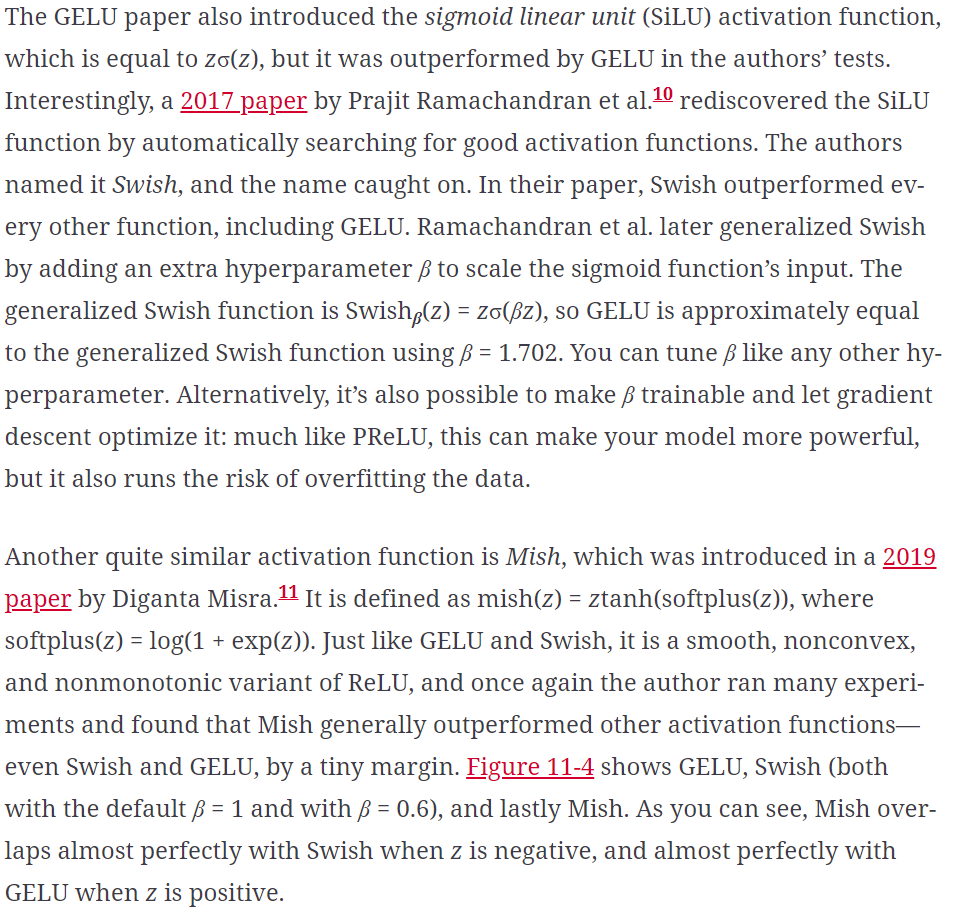

ReLU remains a good default for simple tasks: it’s often just as good as the more sophisticated activation functions, plus it’s very fast to compute, and many libraries and hardware accelerators provide ReLU-specific optimizations. However, Swish is probably a better default for more complex tasks, and you can even try parametrized Swish with a learnable β parameter for the most complex tasks. Mish may give you slightly better results, but it requires a bit more compute. If you care a lot about runtime latency, then you may prefer leaky ReLU, or parametrized leaky ReLU for more complex tasks. For deep MLPs, give SELU a try, but make sure to respect the constraints listed earlier. If you have spare time and computing power, you can use cross-validation to evaluate other activation functions as well.



(-4.0, 2.0, -1.0, 2.0)

Text(0.5, 0, '$z$')

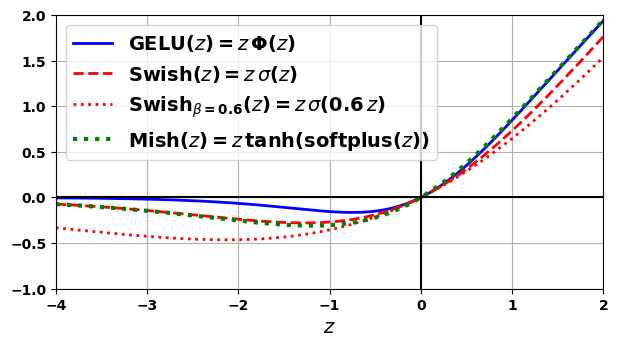

In [31]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

Sergey Ioffe and Christian Szegedy proposed a technique called batch normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set. That is, there’s no need for StandardScaler or Normalization; the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “batch normalization”). The whole operation is summarized step by step in Equation 11-4.
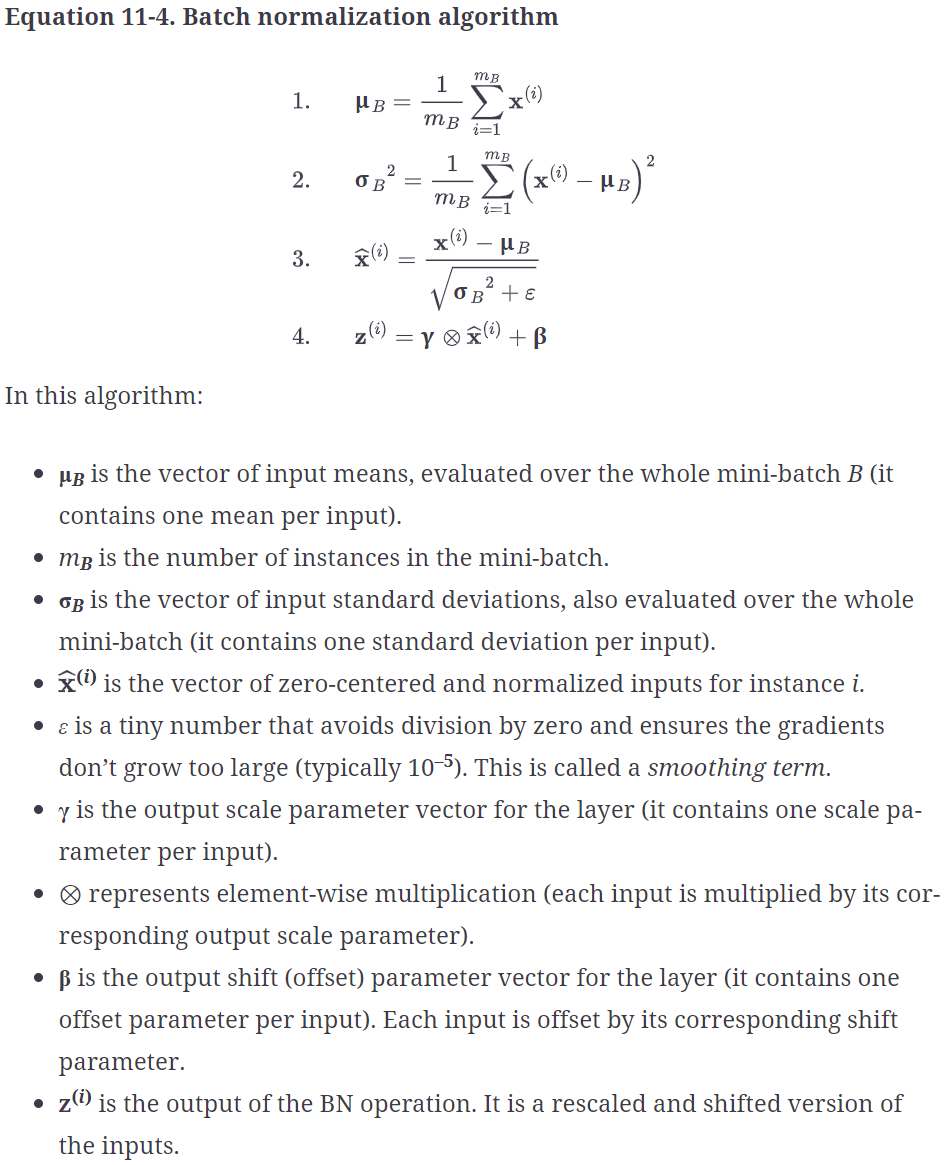
So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of batch normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the BatchNormalization layer. To sum up, four parameter vectors are learned in each batch-normalized layer: γ (the output scale vector) and β (the output offset vector) are learned through regular backpropagation, and μ (the final input mean vector) and σ (the final input standard deviation vector) are estimated using an exponential moving average. Note that μ and σ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-4).
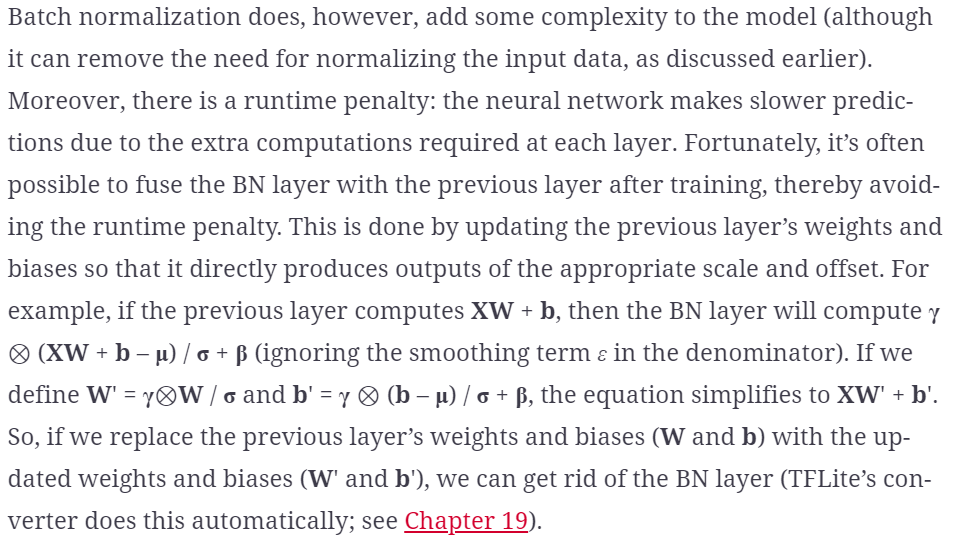

In [32]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [33]:
# this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [35]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [36]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 21s 11ms/step - loss: 0.5436 - accuracy: 0.8095 - val_loss: 0.4030 - val_accuracy: 0.8496
Epoch 2/2
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4033 - accuracy: 0.8569 - val_loss: 0.3640 - val_accuracy: 0.8642


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

Batch normalization has become one of the most-used layers in deep neural networks, especially deep convolutional neural networks discussed in (Chapter 14), to the point that it is often omitted in the architecture diagrams: it is assumed that BN is added after every layer.

In [37]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [39]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 17s 9ms/step - loss: 0.6044 - accuracy: 0.7986 - val_loss: 0.4232 - val_accuracy: 0.8460
Epoch 2/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4247 - accuracy: 0.8508 - val_loss: 0.3721 - val_accuracy: 0.8634


## Gradient Clipping

nother technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called gradient clipping.⁠14 This technique is generally used in recurrent neural networks, where using batch normalization is tricky 


All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [40]:
# This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0.
# This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

The threshold is a hyperparameter you can tune. Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly at the diagonal between the two axes. In practice, this approach works well. If you want to ensure that gradient clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its ℓ2 norm is greater than the threshold you picked. For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component. If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try clipping by value or clipping by norm, with different thresholds, and see which option performs best on the validation set.

In [41]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

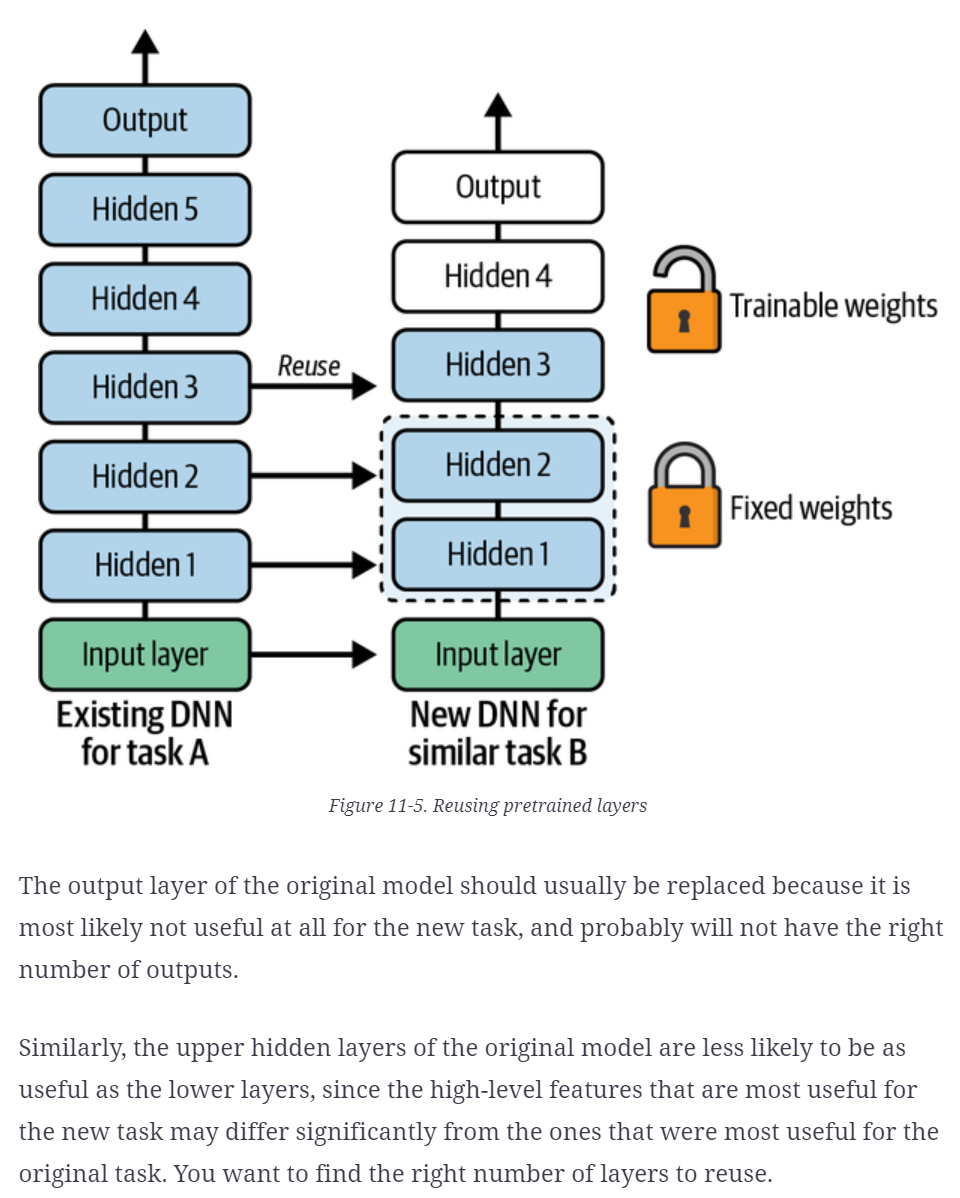
The more similar the tasks are, the more layers you will want to reuse (starting with the lower layers). For very similar tasks, try to keep all the hidden layers and just replace the output layer.

Try freezing all the reused layers first (i.e., make their weights non-trainable so that gradient descent won’t modify them and they will remain fixed), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [42]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 8s 6ms/step - loss: 1.1290 - accuracy: 0.6417 - val_loss: 0.6991 - val_accuracy: 0.7721
Epoch 2/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.6110 - accuracy: 0.8016 - val_loss: 0.5269 - val_accuracy: 0.8233
Epoch 3/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.4971 - accuracy: 0.8384 - val_loss: 0.4543 - val_accuracy: 0.8421
Epoch 4/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.4367 - accuracy: 0.8571 - val_loss: 0.4086 - val_accuracy: 0.8581
Epoch 5/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.3973 - accuracy: 0.8684 - val_loss: 0.3792 - val_accuracy: 0.8669
Epoch 6/20
1376/1376 [==============================] - 8s 5ms/step - loss: 0.3692 - accuracy: 0.8764 - val_loss: 0.3585 - val_accuracy: 0.8782
Epoch 7/20
1376/1376 [==============================] - 8s 6ms/step - loss: 0.3489 - accuracy: 0.8812 - val_loss: 0.3424 - val_accuracy:

In [43]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 106ms/step - loss: 0.7736 - accuracy: 0.4500 - val_loss: 0.7267 - val_accuracy: 0.4738
Epoch 2/20
7/7 [==============================] - 0s 43ms/step - loss: 0.7102 - accuracy: 0.4850 - val_loss: 0.6825 - val_accuracy: 0.5262
Epoch 3/20
7/7 [==============================] - 0s 37ms/step - loss: 0.6677 - accuracy: 0.5800 - val_loss: 0.6500 - val_accuracy: 0.6390
Epoch 4/20
7/7 [==============================] - 0s 39ms/step - loss: 0.6337 - accuracy: 0.6900 - val_loss: 0.6295 - val_accuracy: 0.7082
Epoch 5/20
7/7 [==============================] - 0s 49ms/step - loss: 0.6125 - accuracy: 0.7350 - val_loss: 0.6113 - val_accuracy: 0.7498
Epoch 6/20
7/7 [==============================] - 0s 41ms/step - loss: 0.5934 - accuracy: 0.7800 - val_loss: 0.5949 - val_accuracy: 0.7814
Epoch 7/20
7/7 [==============================] - 0s 43ms/step - loss: 0.5758 - accuracy: 0.8050 - val_loss: 0.5810 - val_accuracy: 0.8032
Epoch 8/20
7/7 [==========

[0.4441318213939667, 0.9014999866485596]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

First, you need to load model A and create a new model based on that model’s layers. You decide to reuse all the layers except for the output layer:

In [44]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])  # reuse all but the output layer
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))  # create a new output layer

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [45]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

Note that model_A and model_B_on_A now share some layers. When you train model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you clone model A’s architecture with clone_model(), then copy its weights.  tf.keras.models.clone_model() only clones the architecture, not the weights. If you don’t copy them manually using set_weights(), they will be initialized randomly when the cloned model is first used.

In [46]:
model_A_clone = tf.keras.models.clone_model(model_A)  # only clones architecture, not the weights
model_A_clone.set_weights(model_A.get_weights())  # get teh weights so they can be cloned

In [47]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Now you could train model_B_on_A for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s trainable attribute to False and compile the model:

In [48]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
# You must always compile your model after you freeze or unfreeze layers.
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights.  You must always compile your model after you freeze or unfreeze layers.  Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights.

In [49]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 76ms/step - loss: 1.0756 - accuracy: 0.5550 - val_loss: 0.8128 - val_accuracy: 0.5124
Epoch 2/4
7/7 [==============================] - 0s 41ms/step - loss: 0.7111 - accuracy: 0.5800 - val_loss: 0.6890 - val_accuracy: 0.5450
Epoch 3/4
7/7 [==============================] - 0s 41ms/step - loss: 0.6588 - accuracy: 0.5850 - val_loss: 0.6746 - val_accuracy: 0.5767
Epoch 4/4
7/7 [==============================] - 0s 40ms/step - loss: 0.6434 - accuracy: 0.6250 - val_loss: 0.6561 - val_accuracy: 0.6073
Epoch 1/16
7/7 [==============================] - 1s 60ms/step - loss: 0.6144 - accuracy: 0.6600 - val_loss: 0.5946 - val_accuracy: 0.7003
Epoch 2/16
7/7 [==============================] - 0s 37ms/step - loss: 0.5613 - accuracy: 0.7550 - val_loss: 0.5439 - val_accuracy: 0.8051
Epoch 3/16
7/7 [==============================] - 0s 37ms/step - loss: 0.5161 - accuracy: 0.8000 - val_loss: 0.5164 - val_accuracy: 0.8101
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [50]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.3167 - accuracy: 0.9190


[0.3166804015636444, 0.9190000295639038]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [51]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers).

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using batch normalization, and reusing parts of a pretrained network (possibly built for an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer. In this section we will present the most popular optimization algorithms: momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, and finally Adam and its variants.



In [52]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [53]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [54]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7106 - accuracy: 0.7542 - val_loss: 0.5010 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4711 - accuracy: 0.8332 - val_loss: 0.4486 - val_accuracy: 0.8336
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4244 - accuracy: 0.8493 - val_loss: 0.4091 - val_accuracy: 0.8542
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3952 - accuracy: 0.8594 - val_loss: 0.3835 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3739 - accuracy: 0.8672 - val_loss: 0.3679 - val_accuracy: 0.8648
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3598 - accuracy: 0.8717 - val_loss: 0.3724 - val_accuracy: 0.8688
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3432 - accuracy: 0.8766 - val_loss: 0.3614 - val_acc

## Momentum optimization
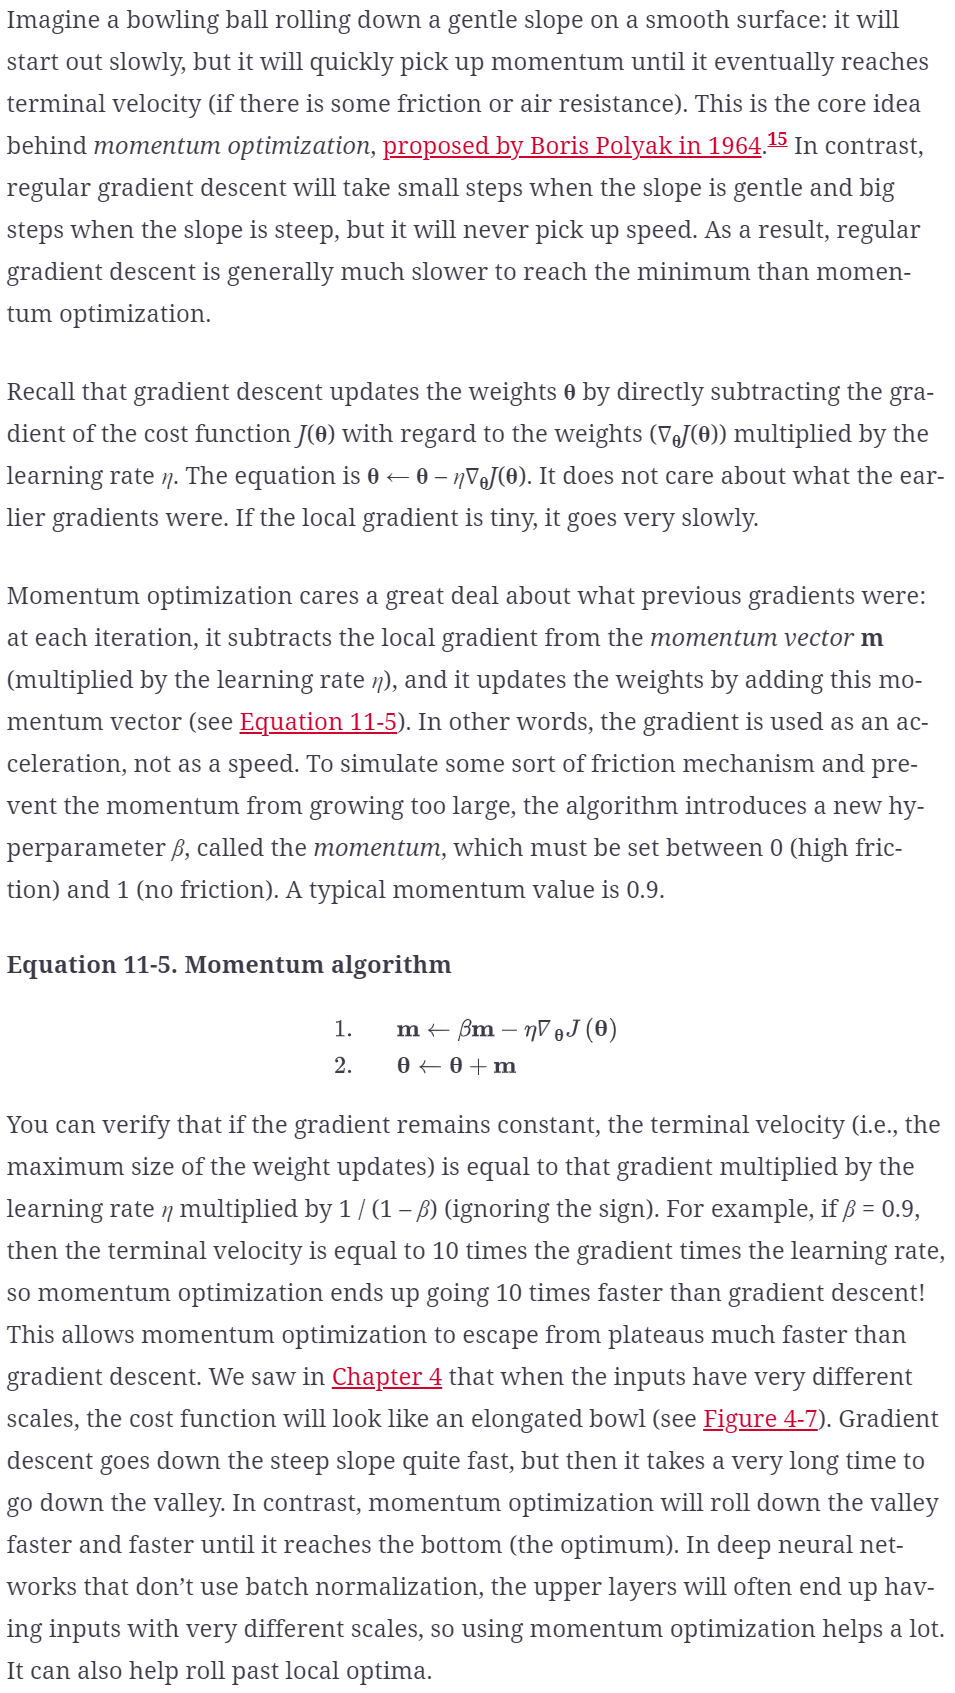

Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.  The momentum value of 0.9 usually works well in practice and almost always goes faster than regular gradient descent.

In [55]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [56]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6880 - accuracy: 0.7695 - val_loss: 0.5054 - val_accuracy: 0.8124
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4687 - accuracy: 0.8357 - val_loss: 0.4503 - val_accuracy: 0.8340
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4252 - accuracy: 0.8511 - val_loss: 0.4209 - val_accuracy: 0.8504
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4000 - accuracy: 0.8601 - val_loss: 0.3862 - val_accuracy: 0.8578
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3789 - accuracy: 0.8651 - val_loss: 0.3696 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3646 - accuracy: 0.8694 - val_loss: 0.3737 - val_accuracy: 0.8648
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3486 - accuracy: 0.8746 - val_loss: 0.3736 - val_ac

## Nesterov Accelerated Gradient
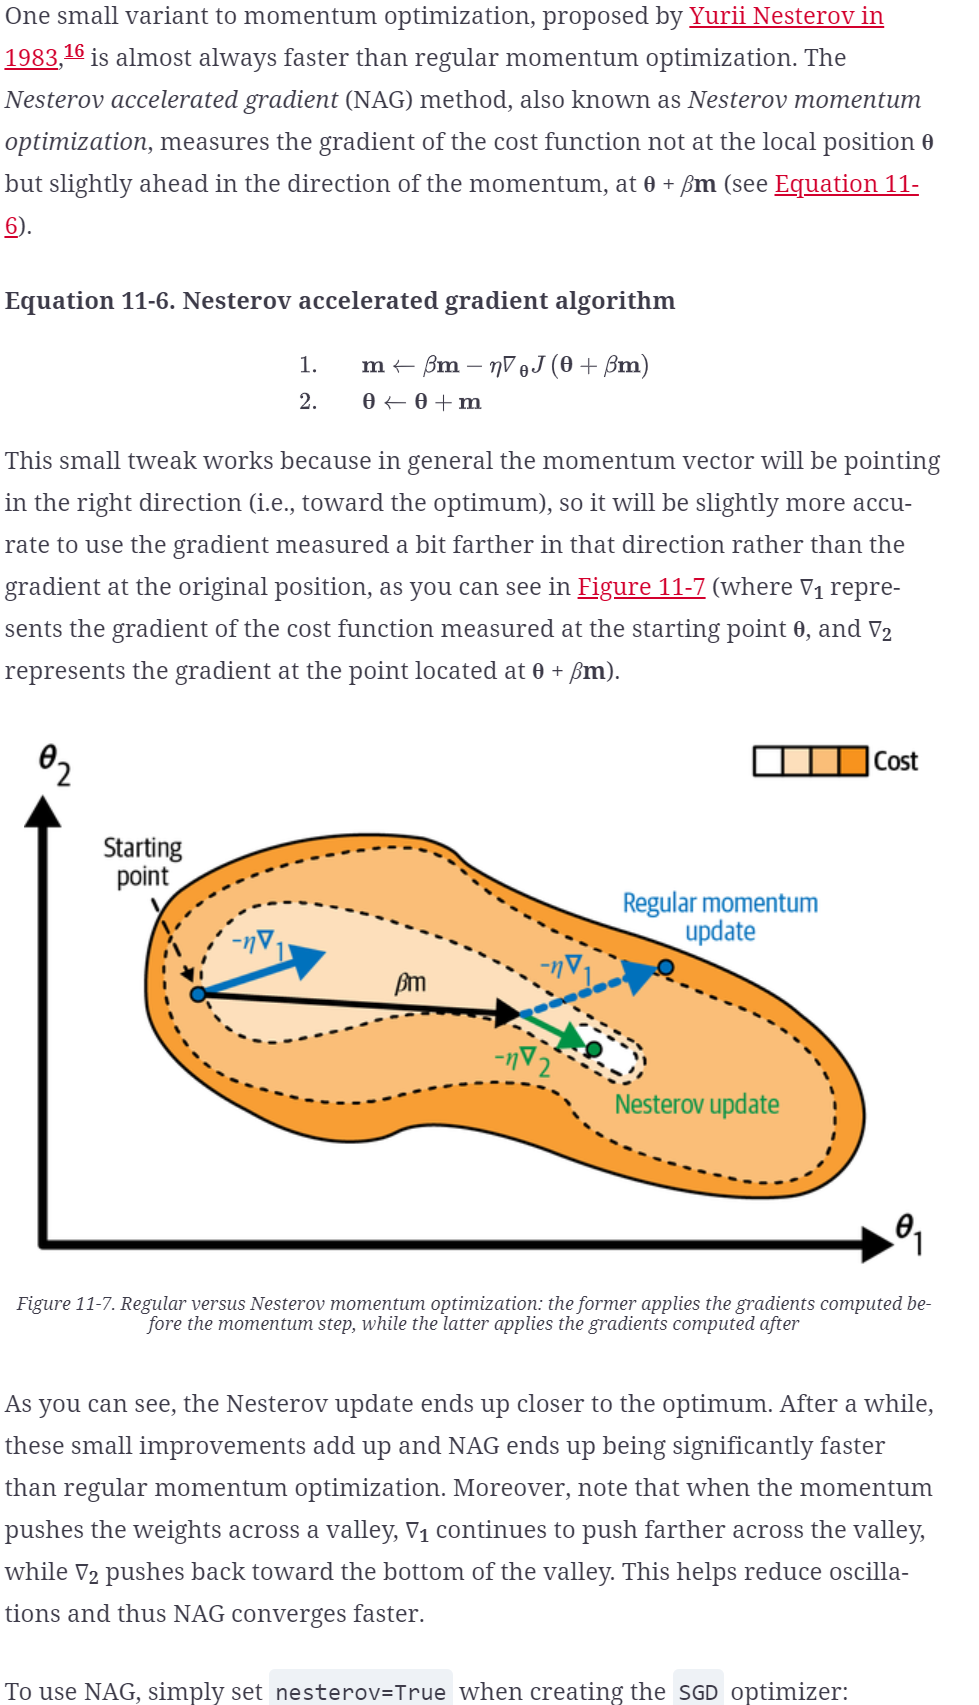

In [57]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [58]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6717 - accuracy: 0.7701 - val_loss: 0.4919 - val_accuracy: 0.8260
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4584 - accuracy: 0.8396 - val_loss: 0.4395 - val_accuracy: 0.8440
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4169 - accuracy: 0.8535 - val_loss: 0.4079 - val_accuracy: 0.8594
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3922 - accuracy: 0.8636 - val_loss: 0.3856 - val_accuracy: 0.8660
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3725 - accuracy: 0.8692 - val_loss: 0.3739 - val_accuracy: 0.8654
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3582 - accuracy: 0.8732 - val_loss: 0.3761 - val_accuracy: 0.8646
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3437 - accuracy: 0.8767 - val_loss: 0.3778 - val_ac

## AdaGrad
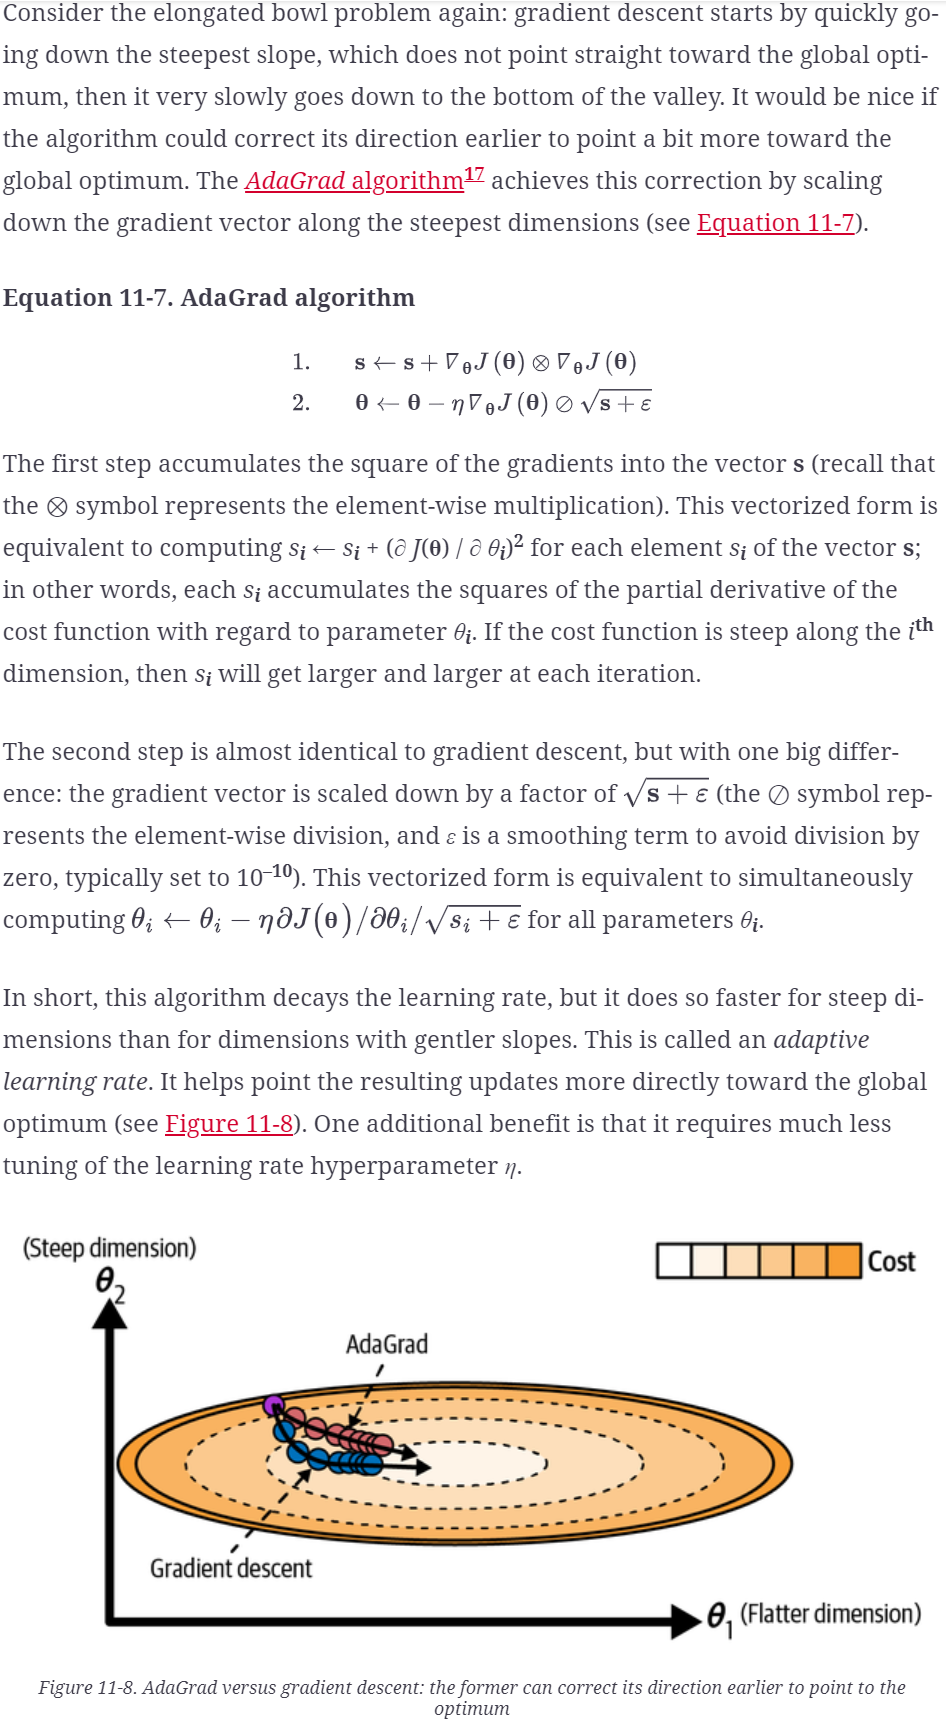
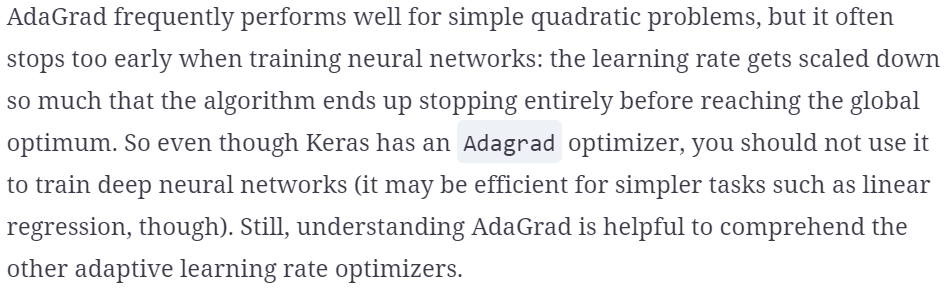

In [59]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [60]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9997 - accuracy: 0.6738 - val_loss: 0.6922 - val_accuracy: 0.7742
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6386 - accuracy: 0.7853 - val_loss: 0.5813 - val_accuracy: 0.7996
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5642 - accuracy: 0.8087 - val_loss: 0.5324 - val_accuracy: 0.8172
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5274 - accuracy: 0.8209 - val_loss: 0.5073 - val_accuracy: 0.8238
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5038 - accuracy: 0.8277 - val_loss: 0.4891 - val_accuracy: 0.8262
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4866 - accuracy: 0.8328 - val_loss: 0.4764 - val_accuracy: 0.8304
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4736 - accuracy: 0.8369 - val_loss: 0.4635 - val_ac

## RMSProp
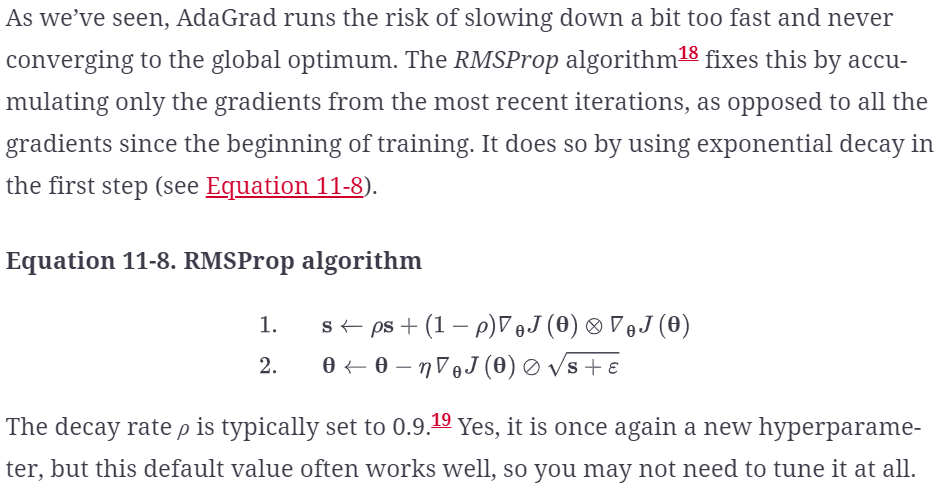
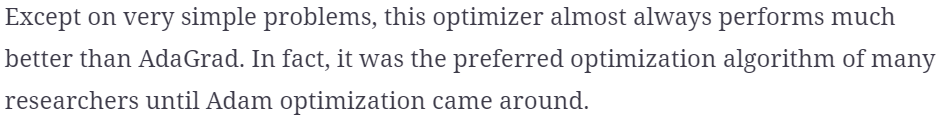

In [61]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [62]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.5149 - accuracy: 0.8142 - val_loss: 0.4661 - val_accuracy: 0.8296
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3957 - accuracy: 0.8582 - val_loss: 0.4036 - val_accuracy: 0.8532
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3702 - accuracy: 0.8692 - val_loss: 0.4031 - val_accuracy: 0.8688
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3659 - accuracy: 0.8744 - val_loss: 0.4228 - val_accuracy: 0.8638
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3604 - accuracy: 0.8778 - val_loss: 0.4706 - val_accuracy: 0.8484
Epoch 6/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.3572 - accuracy: 0.8786 - val_loss: 0.5189 - val_accuracy: 0.8618
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3587 - accuracy: 0.8792 - val_loss: 0.4799 - val_ac

## Adam Optimization
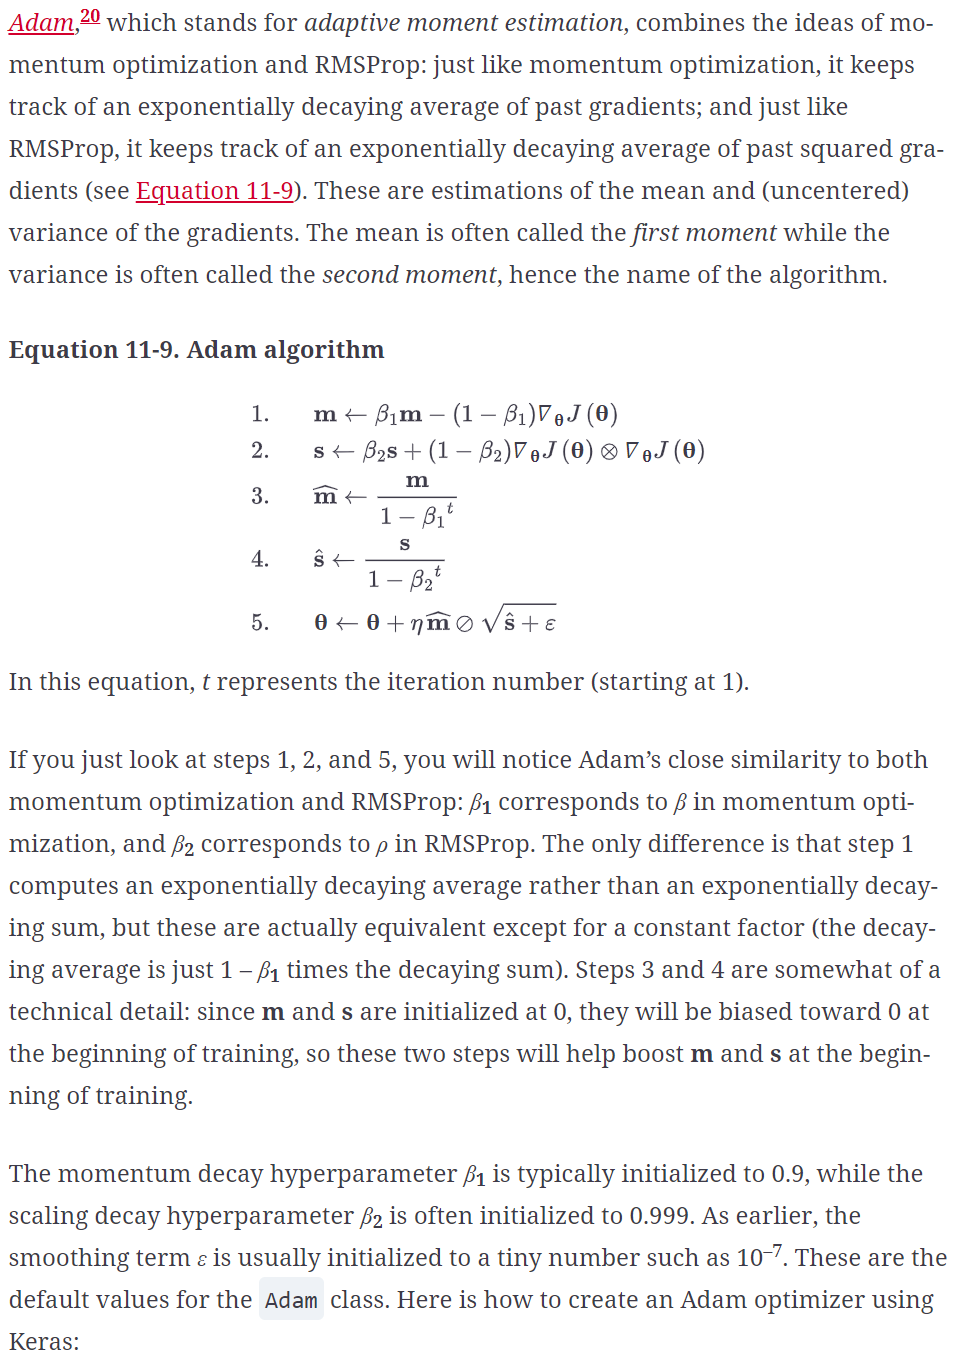
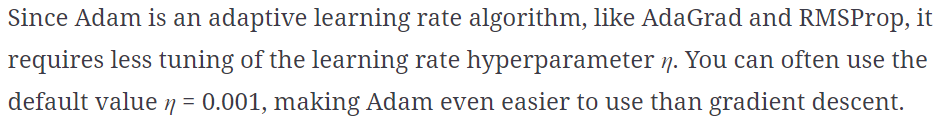

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [64]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4975 - accuracy: 0.8220 - val_loss: 0.4067 - val_accuracy: 0.8446
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3756 - accuracy: 0.8637 - val_loss: 0.3901 - val_accuracy: 0.8566
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3410 - accuracy: 0.8747 - val_loss: 0.3711 - val_accuracy: 0.8690
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3177 - accuracy: 0.8838 - val_loss: 0.3322 - val_accuracy: 0.8776
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2999 - accuracy: 0.8883 - val_loss: 0.3265 - val_accuracy: 0.8782
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2851 - accuracy: 0.8938 - val_loss: 0.3613 - val_accuracy: 0.8732
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2727 - accuracy: 0.8976 - val_loss: 0.3340 - val_ac

**Adamax Optimization**
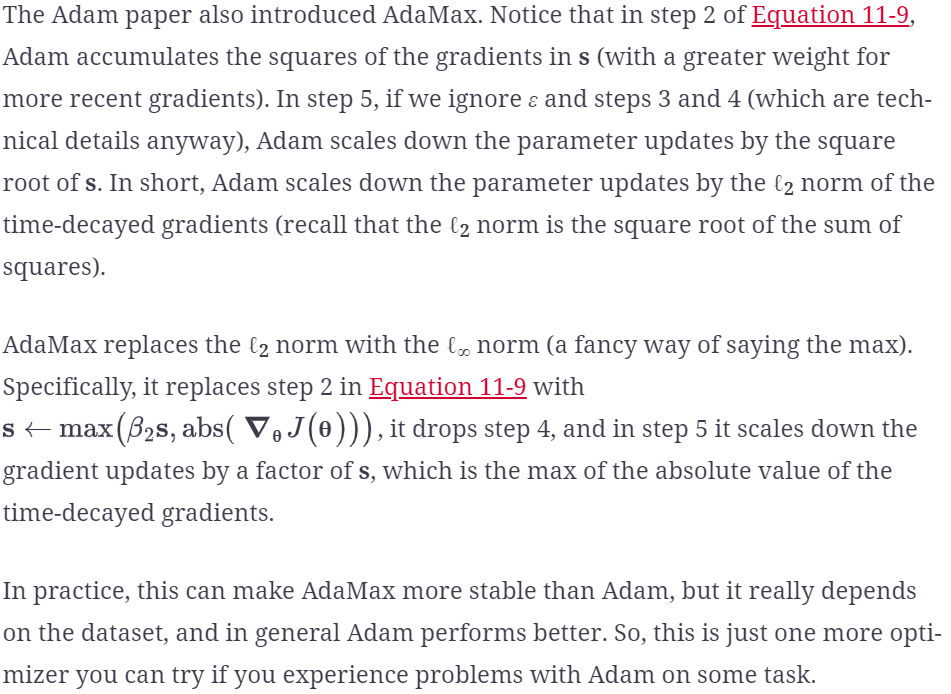

In [65]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [66]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5340 - accuracy: 0.8128 - val_loss: 0.4425 - val_accuracy: 0.8376
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3975 - accuracy: 0.8586 - val_loss: 0.3849 - val_accuracy: 0.8596
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3597 - accuracy: 0.8696 - val_loss: 0.3697 - val_accuracy: 0.8646
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3333 - accuracy: 0.8801 - val_loss: 0.3389 - val_accuracy: 0.8738
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3125 - accuracy: 0.8854 - val_loss: 0.3287 - val_accuracy: 0.8770
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2993 - accuracy: 0.8911 - val_loss: 0.3331 - val_accuracy: 0.8790
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2856 - accuracy: 0.8955 - val_loss: 0.3375 - val_acc

**Nadam Optimization**
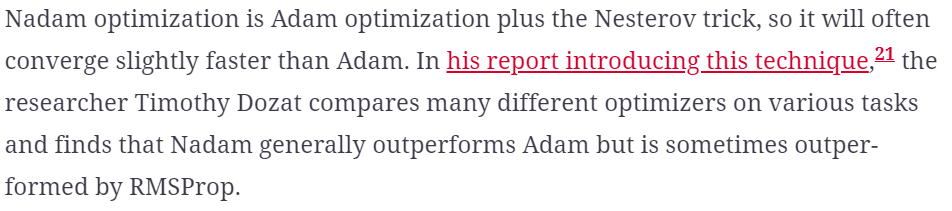

In [67]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [68]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.4826 - accuracy: 0.8264 - val_loss: 0.4136 - val_accuracy: 0.8372
Epoch 2/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3598 - accuracy: 0.8680 - val_loss: 0.3668 - val_accuracy: 0.8610
Epoch 3/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3254 - accuracy: 0.8803 - val_loss: 0.3485 - val_accuracy: 0.8726
Epoch 4/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.3045 - accuracy: 0.8883 - val_loss: 0.3434 - val_accuracy: 0.8768
Epoch 5/10
1719/1719 [==============================] - 21s 13ms/step - loss: 0.2874 - accuracy: 0.8927 - val_loss: 0.3317 - val_accuracy: 0.8762
Epoch 6/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2745 - accuracy: 0.8974 - val_loss: 0.3275 - val_accuracy: 0.8862
Epoch 7/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.2620 - accuracy: 0.9012 - val_loss: 0.3409 -

**AdamW Optimization**
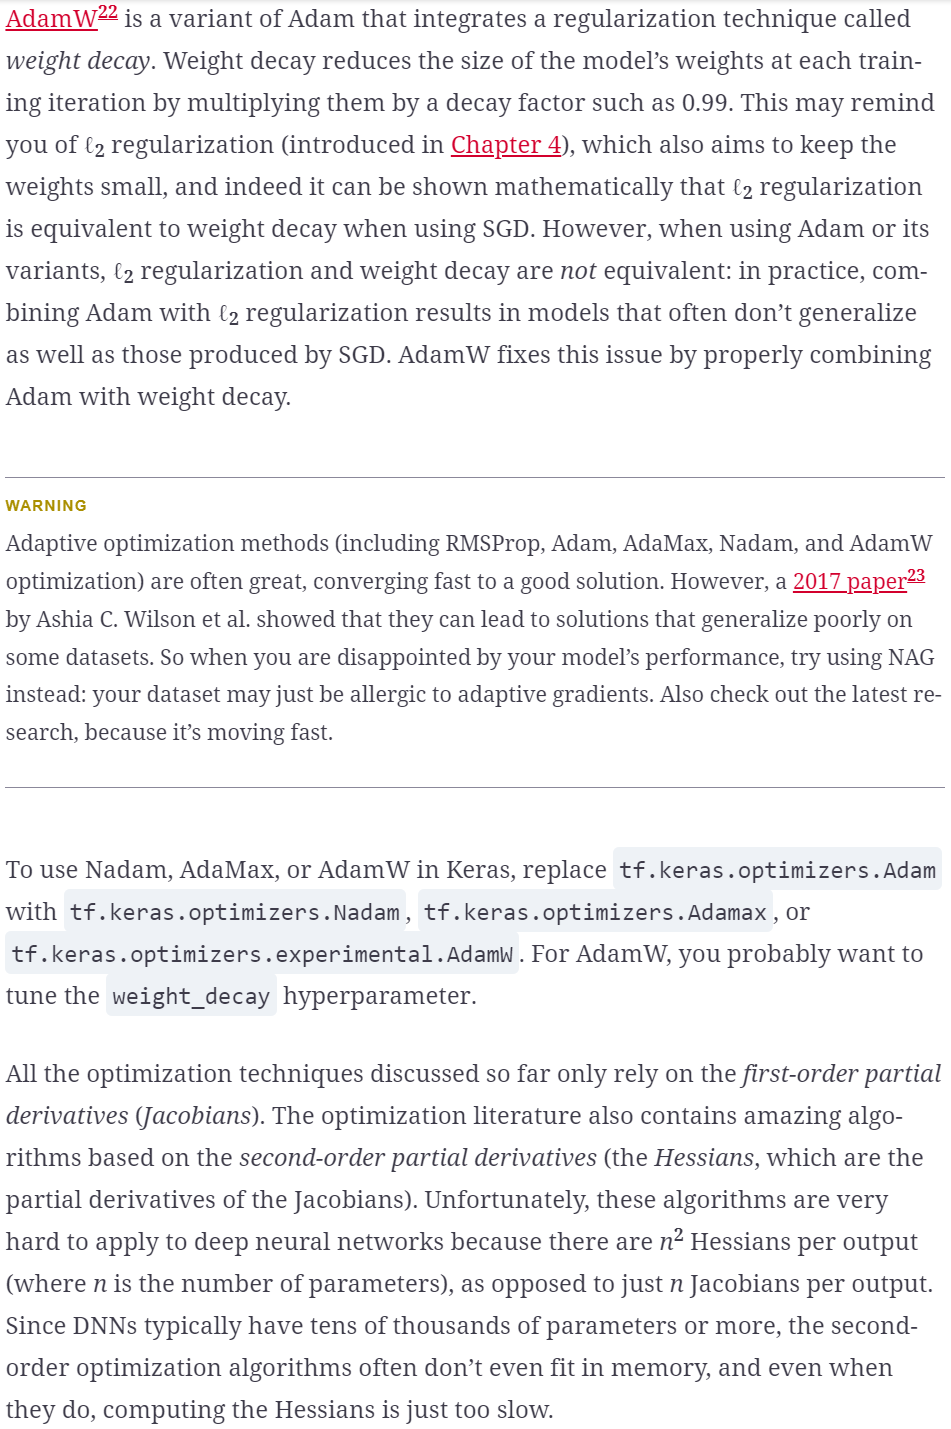

On Colab or Kaggle, we need to install the TensorFlow-Addons library:

In [69]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

In [70]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

C:\Users\donda\anaconda3\envs\handsOnML\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [71]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4949 - accuracy: 0.8216 - val_loss: 0.4063 - val_accuracy: 0.8420
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3731 - accuracy: 0.8630 - val_loss: 0.4096 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3392 - accuracy: 0.8763 - val_loss: 0.3528 - val_accuracy: 0.8740
Epoch 4/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3167 - accuracy: 0.8832 - val_loss: 0.3388 - val_accuracy: 0.8740
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2975 - accuracy: 0.8891 - val_loss: 0.3397 - val_accuracy: 0.8714
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2838 - accuracy: 0.8936 - val_loss: 0.3513 - val_accuracy: 0.8772
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2734 - accuracy: 0.8974 - val_loss: 0.3518 - val_ac

<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Training loss')

(0.0, 9.0, 0.1, 0.7)

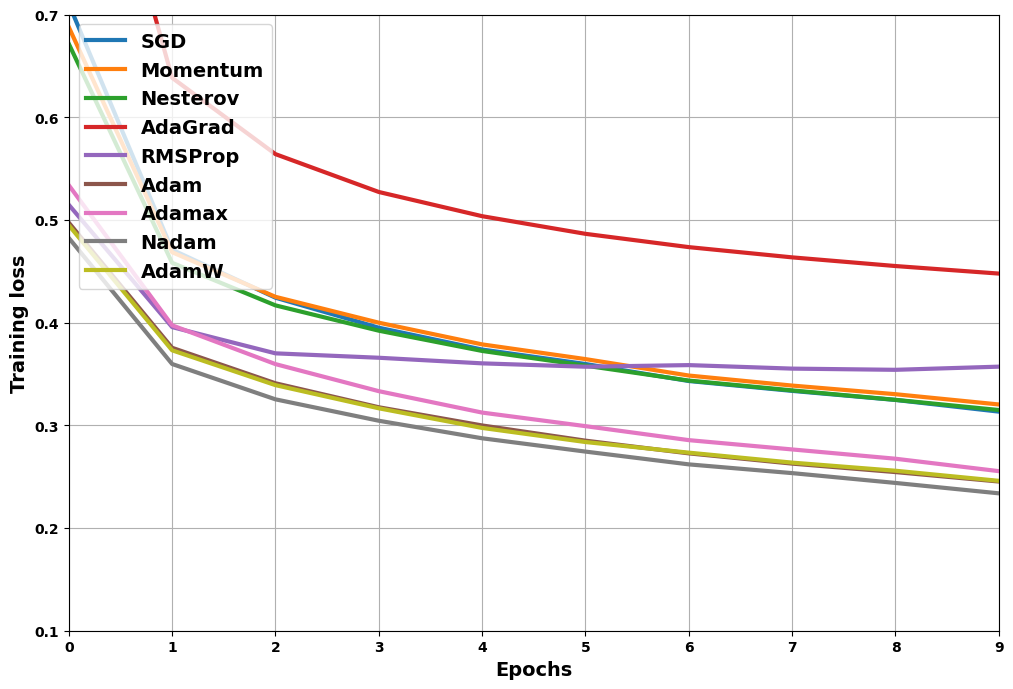

<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Validation loss')

(0.0, 9.0, 0.1, 0.7)

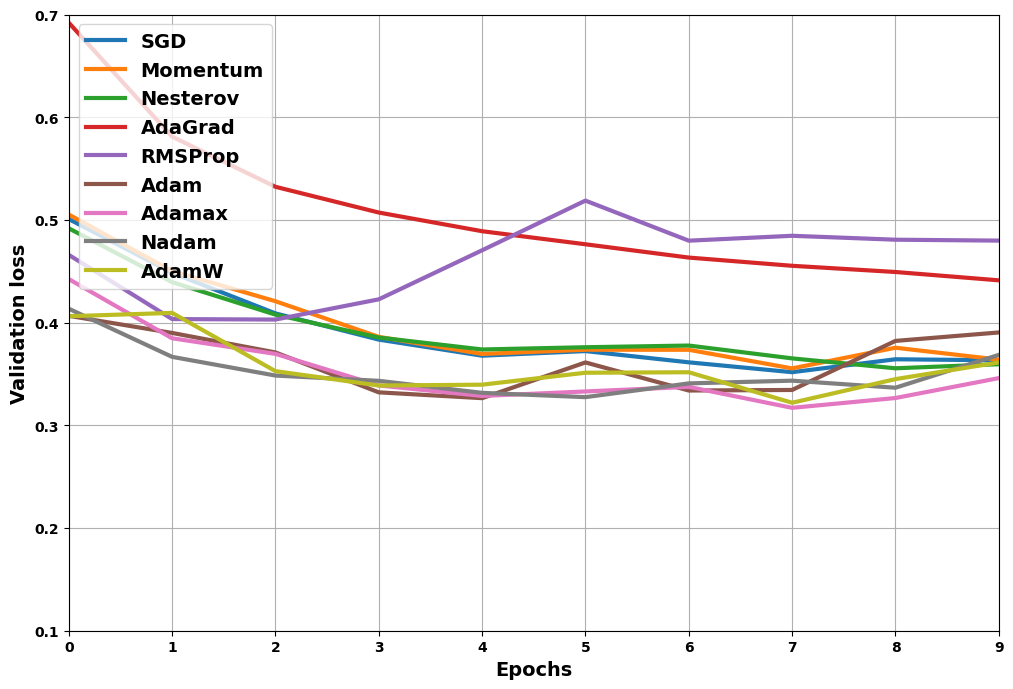

In [72]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

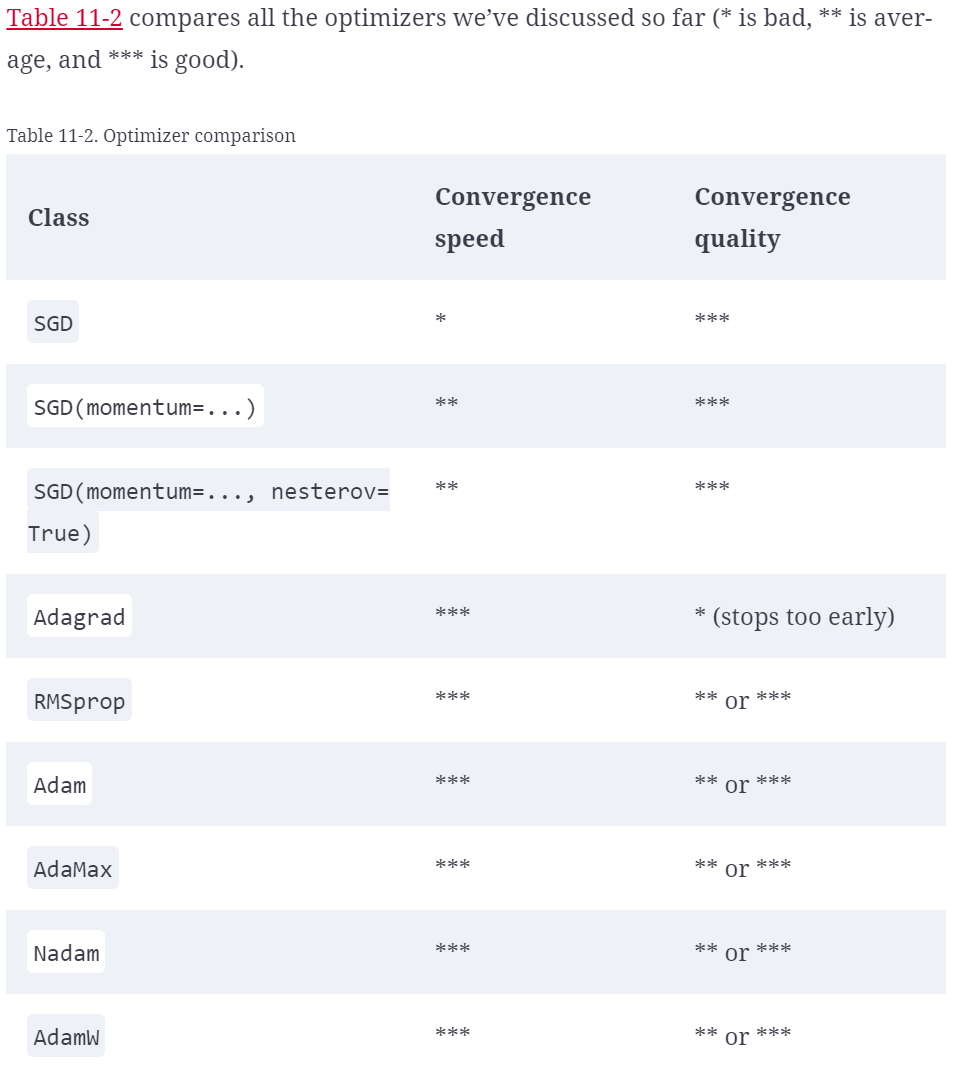

## Learning Rate Scheduling
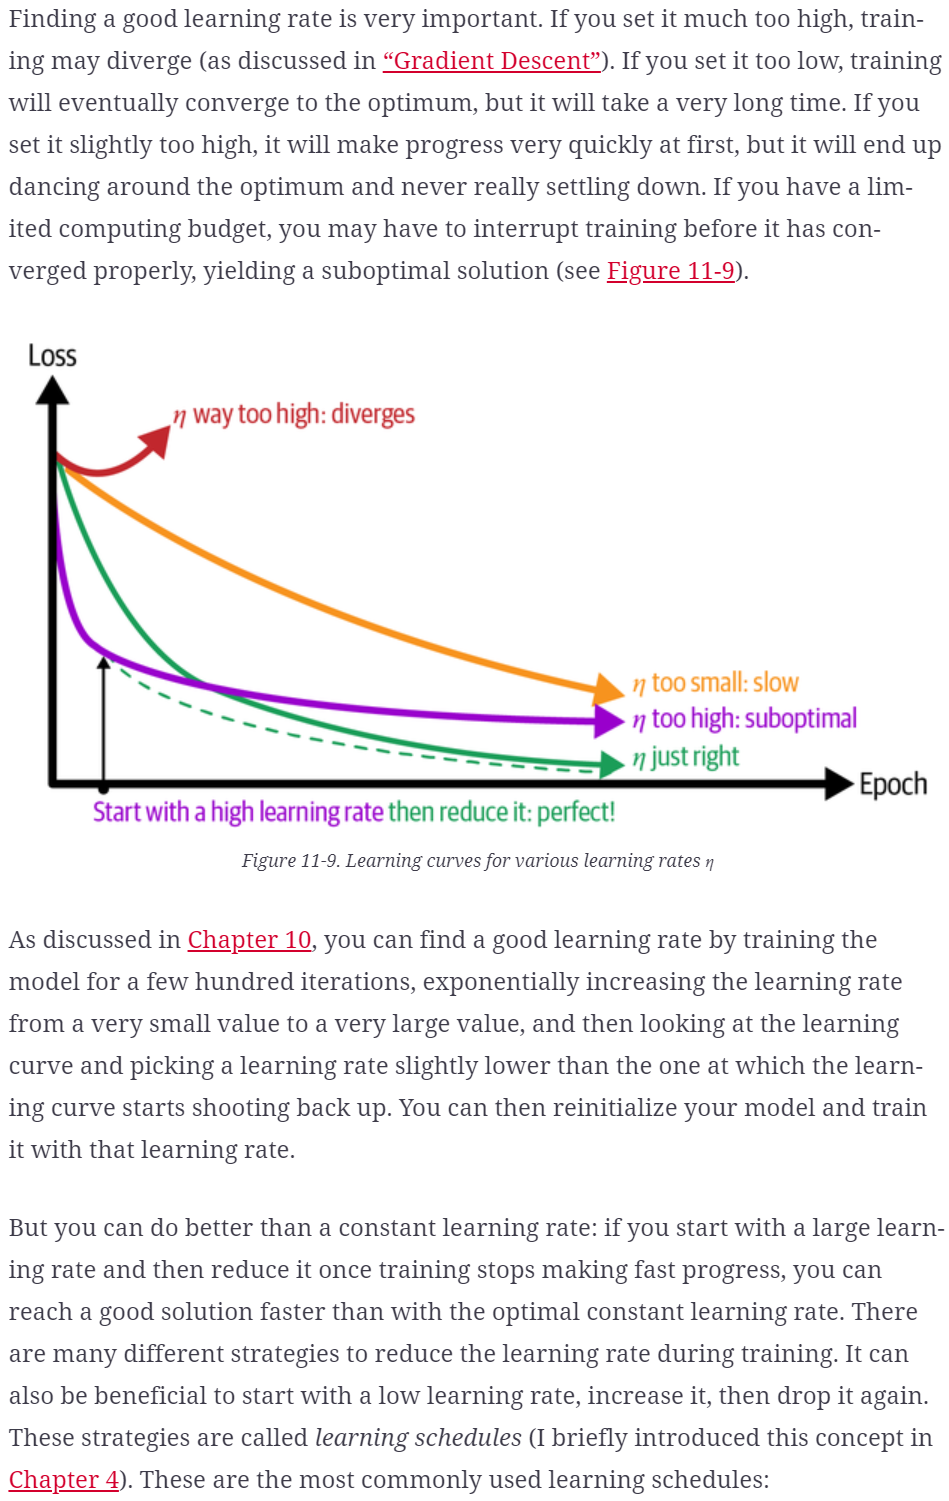

### Power Scheduling
Set the learning rate to a function of the iteration number t: η(t) = η0 / (1 + t/s)c. The initial learning rate η0, the power c (typically set to 1), and the steps s are hyperparameters. The learning rate drops at each step. After s steps, the learning rate is down to η0 / 2. After s more steps it is down to η0 / 3, then it goes down to η0 / 4, then η0 / 5, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning η0 and s (and possibly c).

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [73]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [74]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6774 - accuracy: 0.7687 - val_loss: 0.4948 - val_accuracy: 0.8210
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4737 - accuracy: 0.8347 - val_loss: 0.4629 - val_accuracy: 0.8322
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4295 - accuracy: 0.8496 - val_loss: 0.4177 - val_accuracy: 0.8496
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4071 - accuracy: 0.8573 - val_loss: 0.3978 - val_accuracy: 0.8586
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3890 - accuracy: 0.8623 - val_loss: 0.3898 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3753 - accuracy: 0.8669 - val_loss: 0.3909 - val_accuracy: 0.8600
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3654 - accuracy: 0.8700 - val_loss: 0.3758 - val_accuracy

(0.0, 24.0, 0.0, 0.01)

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Learning Rate')

Text(0.5, 1.0, 'Power Scheduling')

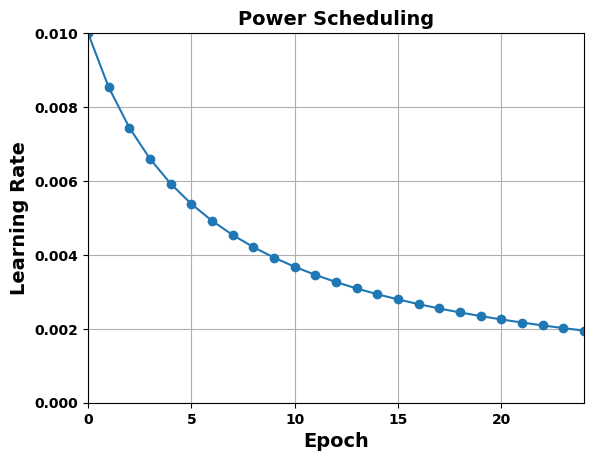

In [75]:
# extra code – this cell plots power scheduling

import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling
Set the learning rate to η(t) = η0 0.1t/s. The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

```lr = lr0 * 0.1 ** (epoch / s)```

In [76]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [77]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [78]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [79]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6978 - accuracy: 0.7606 - val_loss: 0.4960 - val_accuracy: 0.8216 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 6ms/step - loss: 0.4682 - accuracy: 0.8343 - val_loss: 0.4521 - val_accuracy: 0.8354 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4216 - accuracy: 0.8491 - val_loss: 0.4166 - val_accuracy: 0.8574 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3978 - accuracy: 0.8592 - val_loss: 0.3895 - val_accuracy: 0.8634 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3788 - accuracy: 0.8643 - val_loss: 0.3804 - val_accuracy: 0.8646 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3647 - accuracy: 0.8698 - val_loss: 0.3881 - val_accuracy: 0.8642 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] 

(0.0, 24.0, 0.0, 0.011)

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Learning Rate')

Text(0.5, 1.0, 'Exponential Scheduling')

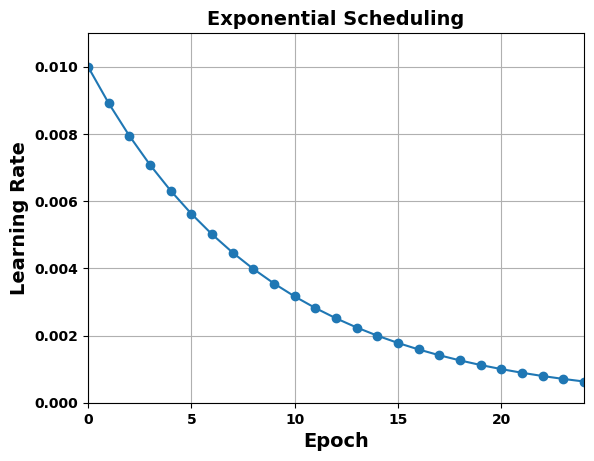

In [80]:
# extra code – this cell plots exponential scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [81]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [82]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [83]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [84]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6822 - accuracy: 0.7661 - val_loss: 0.4937 - val_accuracy: 0.8232 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4723 - accuracy: 0.8336 - val_loss: 0.4536 - val_accuracy: 0.8372 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4253 - accuracy: 0.8484 - val_loss: 0.4116 - val_accuracy: 0.8560 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4004 - accuracy: 0.8592 - val_loss: 0.3841 - val_accuracy: 0.8626 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3808 - accuracy: 0.8649 - val_loss: 0.3764 - val_accuracy: 0.8644 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3654 - accuracy: 0.8696 - val_loss: 0.3807 - val_accuracy: 0.8614 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================

(0.0, 42974.0, 0.0, 0.011000000000000001)

Text(0.5, 0, 'Batch')

Text(0, 0.5, 'Learning Rate')

Text(0.5, 1.0, 'Exponential Scheduling (per batch)')

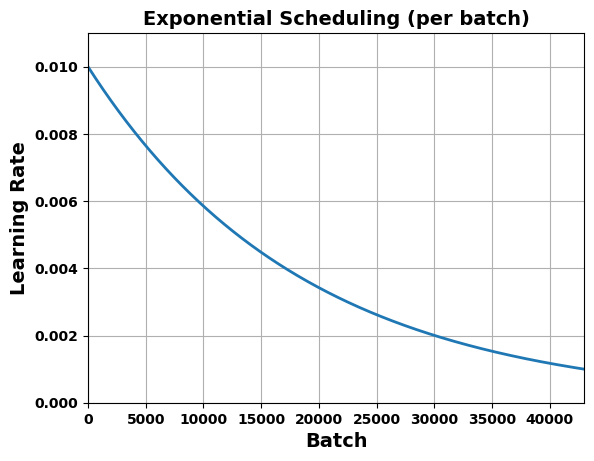

In [85]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling
Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

In [86]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [87]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [88]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 21s 12ms/step - loss: 0.5672 - accuracy: 0.7974 - val_loss: 0.5977 - val_accuracy: 0.7886 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4513 - accuracy: 0.8398 - val_loss: 0.4512 - val_accuracy: 0.8352 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 20s 11ms/step - loss: 0.4279 - accuracy: 0.8497 - val_loss: 0.4252 - val_accuracy: 0.8558 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 20s 12ms/step - loss: 0.4236 - accuracy: 0.8511 - val_loss: 0.4205 - val_accuracy: 0.8534 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 20s 12ms/step - loss: 0.4173 - accuracy: 0.8554 - val_loss: 0.4281 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3597 - accuracy: 0.8713 - val_loss: 0.3975 - val_accuracy: 0.8592 - lr: 0.0050
Epoch 7/25
1719/1719 [========================

(0.0, 24.0, 0.0, 0.011)

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Learning Rate')

Text(0.5, 1.0, 'Piecewise Constant Scheduling')

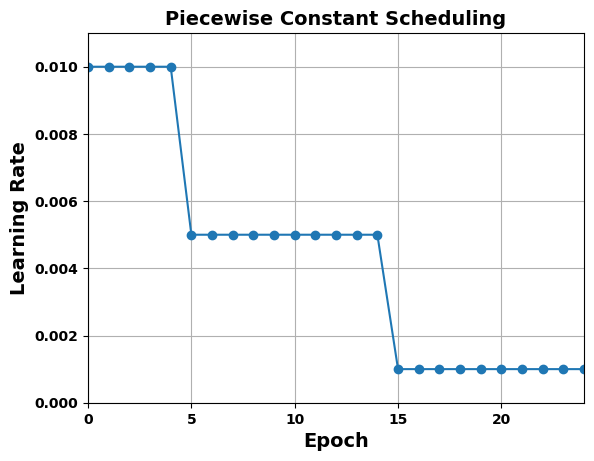

In [89]:
# extra code – this cell plots piecewise constant scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling
Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.

In [90]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [91]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6996 - accuracy: 0.7556 - val_loss: 0.4960 - val_accuracy: 0.8256 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4667 - accuracy: 0.8353 - val_loss: 0.4896 - val_accuracy: 0.8190 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4179 - accuracy: 0.8503 - val_loss: 0.4171 - val_accuracy: 0.8534 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3935 - accuracy: 0.8609 - val_loss: 0.3867 - val_accuracy: 0.8612 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3727 - accuracy: 0.8667 - val_loss: 0.3767 - val_accuracy: 0.8616 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3568 - accuracy: 0.8715 - val_loss: 0.3845 - val_accuracy: 0.8662 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 9s

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Learning Rate')

(0.0, 24.0)

Text(0, 0.5, 'Validation Loss')

Text(0.5, 1.0, 'Reduce LR on Plateau')

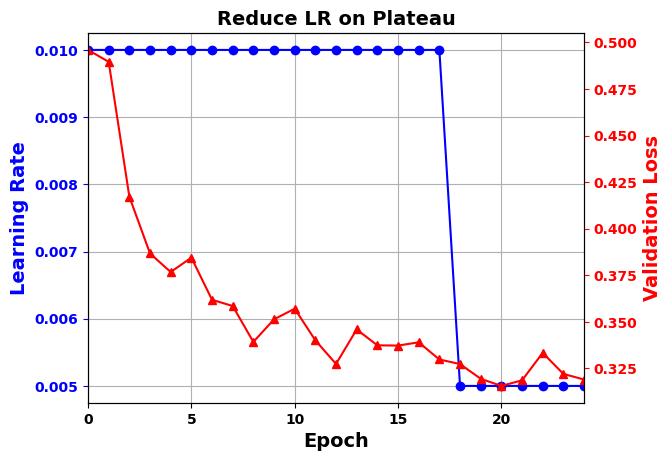

In [92]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [93]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [94]:
# extra code – build and train the model
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6790 - accuracy: 0.7683 - val_loss: 0.4750 - val_accuracy: 0.8298
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4703 - accuracy: 0.8360 - val_loss: 0.4425 - val_accuracy: 0.8388
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4226 - accuracy: 0.8503 - val_loss: 0.4153 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3983 - accuracy: 0.8593 - val_loss: 0.3842 - val_accuracy: 0.8612
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3781 - accuracy: 0.8657 - val_loss: 0.3741 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3629 - accuracy: 0.8710 - val_loss: 0.3859 - val_accuracy: 0.8614
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3522 - accuracy: 0.8740 - val_loss: 0.3599 - val_accuracy:

For piecewise constant scheduling, try this:

In [95]:
# extra code – shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling
1cycle was introduced in a 2018 paper by Leslie Smith.⁠24 Contrary to the other approaches, it starts by increasing the initial learning rate η0, growing linearly up to η1 halfway through training. Then it decreases the learning rate linearly down to η0 again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate η1 is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate η0 is usually 10 times lower. When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, compared to 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture). This feat was dubbed super-convergence.

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [96]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [97]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [98]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [99]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 3s 7ms/step - loss: 2110712955510194176.0000 - accuracy: 0.3980


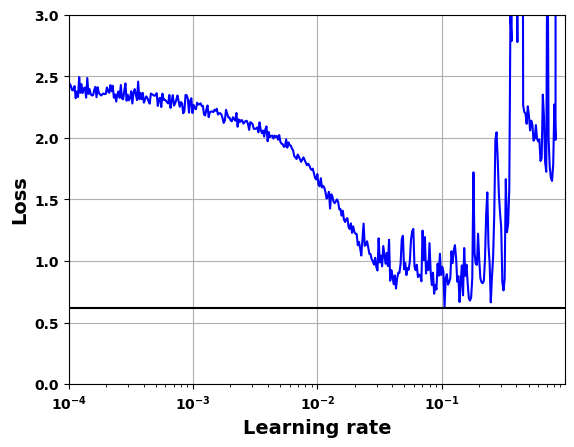

In [100]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [101]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [102]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 3s 7ms/step - loss: 1.0317 - accuracy: 0.6726 - val_loss: 0.6065 - val_accuracy: 0.7958
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.5724 - accuracy: 0.7997 - val_loss: 0.5011 - val_accuracy: 0.8236
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.5021 - accuracy: 0.8223 - val_loss: 0.4562 - val_accuracy: 0.8376
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.4555 - accuracy: 0.8383 - val_loss: 0.4320 - val_accuracy: 0.8412
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4268 - accuracy: 0.8471 - val_loss: 0.4403 - val_accuracy: 0.8410
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4013 - accuracy: 0.8560 - val_loss: 0.5141 - val_accuracy: 0.8086
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3826 - accuracy: 0.8624 - val_loss: 0.4047 - val_accuracy: 0.8542
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization
Just like you did in Chapter 4 for simple linear models, you can use ℓ2 regularization to constrain a neural network’s connection weights, and/or ℓ1 regularization if you want a sparse model (with many weights equal to 0). Here is how to apply ℓ2 regularization to a Keras layer’s connection weights, using a regularization factor of 0.01:

In [103]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [104]:
tf.random.set_seed(42)  # extra code – for reproducibility

The l2() function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. As you might expect, you can just use tf.keras.regularizers.l1() if you want ℓ1 regularization; if you want both ℓ1 and ℓ2 regularization, use tf.keras.regularizers.l1_l2() (specifying both regularization factors).

Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s functools.partial() function, which lets you create a thin wrapper for any callable, with some default argument values:

In [105]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

As we saw earlier, ℓ2 regularization is fine when using SGD, momentum optimization, and Nesterov momentum optimization, but not with Adam and its variants. If you want to use Adam with weight decay, then do not use ℓ2 regularization: use AdamW instead.

In [106]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 6ms/step - loss: 3.1154 - accuracy: 0.7704 - val_loss: 1.8633 - val_accuracy: 0.8200
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 1.4284 - accuracy: 0.8125 - val_loss: 1.1308 - val_accuracy: 0.8180


## Dropout
Dropout is one of the most popular regularization techniques for deep neural networks. It was proposed in a paper⁠26 by Geoffrey Hinton et al. in 2012 and further detailed in a 2014 paper⁠27 by Nitish Srivastava et al., and it has proven to be highly successful: many state-of-the-art neural networks use dropout, as it gives them a 1%–2% accuracy boost. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily “dropped out”, meaning it will be entirely ignored during this training step, but it may be active during the next step (see Figure 11-10). The hyperparameter p is called the dropout rate, and it is typically set between 10% and 50%: closer to 20%–30% in recurrent neural nets (see Chapter 15), and closer to 40%–50% in convolutional neural networks (see Chapter 14). After training, neurons don’t get dropped anymore. And that’s all (except for a technical detail we will discuss momentarily).

It’s surprising at first that this destructive technique works at all. Would a company perform better if its employees were told to toss a coin every morning to decide whether or not to go to work? Well, who knows; perhaps it would! The company would be forced to adapt its organization; it could not rely on any single person to work the coffee machine or perform any other critical tasks, so this expertise would have to be spread across several people. Employees would have to learn to cooperate with many of their coworkers, not just a handful of them. The company would become much more resilient. If one person quit, it wouldn’t make much of a difference. It’s unclear whether this idea would actually work for companies, but it certainly does for neural networks. Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there are a total of 2N possible networks (where N is the total number of droppable neurons). This is such a huge number that it is virtually impossible for the same neural network to be sampled twice. Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks, each with just one training instance. These neural networks are obviously not independent because they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.

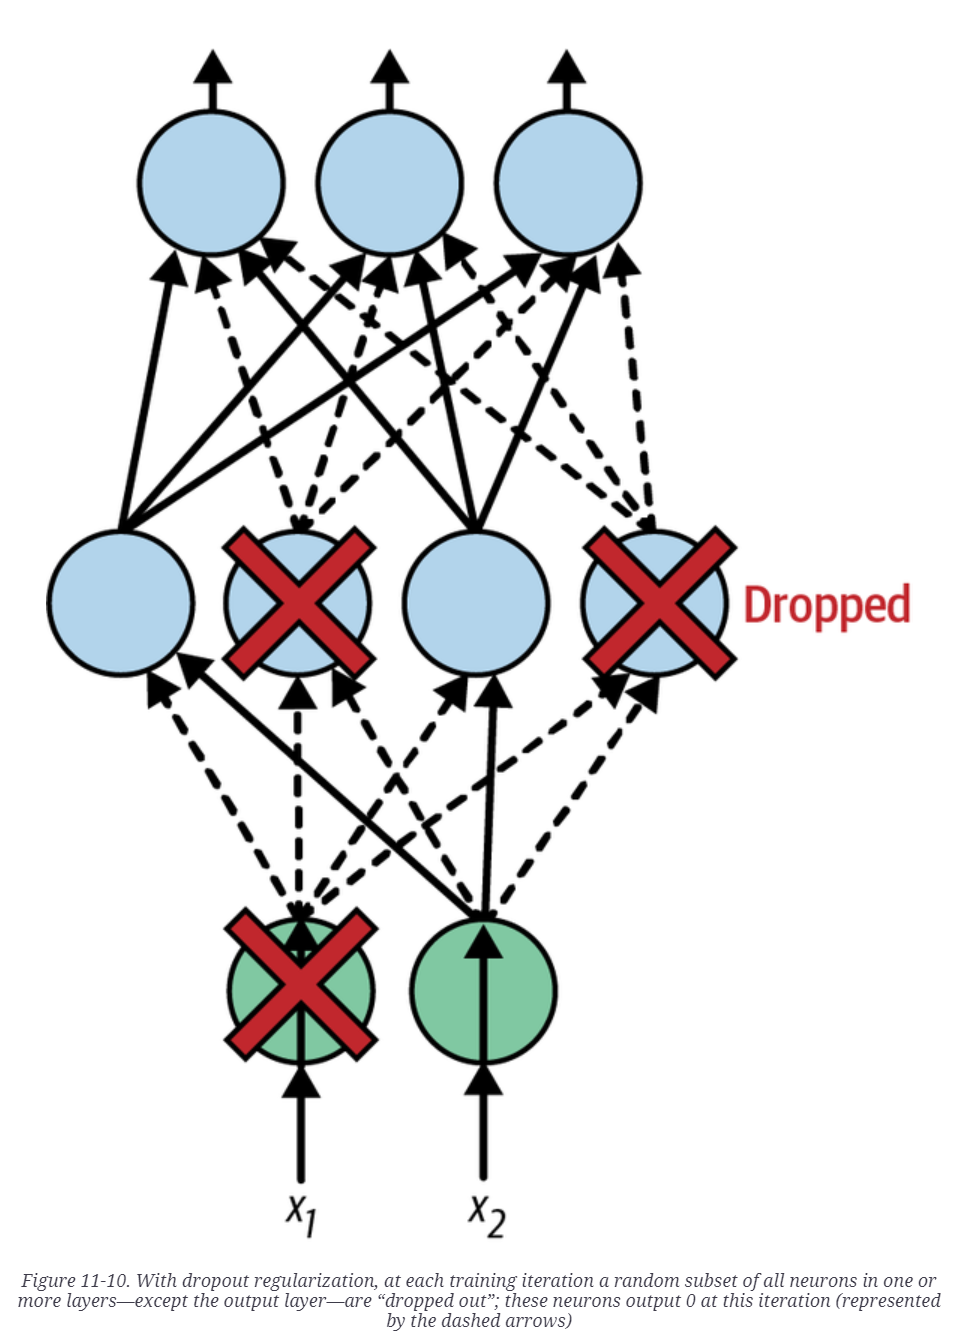

In [107]:
tf.random.set_seed(42)  # extra code – for reproducibility

There is one small but important technical detail. Suppose p = 75%: on average only 25% of all neurons are active at each step during training. This means that after training, a neuron would be connected to four times as many input neurons as it would be during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by four during training. If we don’t, the neural network will not perform well as it will see different data during and after training. More generally, we need to divide the connection weights by the keep probability (1 – p) during training.

To implement dropout using Keras, you can use the tf.keras.layers.Dropout layer. During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability. After training, it does nothing at all; it just passes the inputs to the next layer. The following code applies dropout regularization before every dense layer, using a dropout rate of 0.2:

In [108]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [109]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6766 - accuracy: 0.7517 - val_loss: 0.4644 - val_accuracy: 0.8256
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5152 - accuracy: 0.8119 - val_loss: 0.4171 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4748 - accuracy: 0.8266 - val_loss: 0.3920 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4495 - accuracy: 0.8345 - val_loss: 0.3879 - val_accuracy: 0.8576
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4357 - accuracy: 0.8394 - val_loss: 0.3629 - val_accuracy: 0.8636
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4294 - accuracy: 0.8422 - val_loss: 0.3670 - val_accuracy: 0.8600
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4127 - accuracy: 0.8477 - val_loss: 0.3634 - val_ac

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [110]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 6s 3ms/step - loss: 0.3136 - accuracy: 0.8846


[0.31364762783050537, 0.8845999836921692]

In [111]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3726 - accuracy: 0.8653


[0.37264177203178406, 0.8652999997138977]

If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate if the model underfits the training set. It can also help to increase the dropout rate for large layers, and reduce it for small ones. Moreover, many state-of-the-art architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong.

Dropout does tend to significantly slow down convergence, but it often results in a better model when tuned properly. So, it is generally well worth the extra time and effort, especially for large models.

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout
In 2016, a paper⁠28 by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout:

First, the paper established a profound connection between dropout networks (i.e., neural networks containing Dropout layers) and approximate Bayesian inference,⁠29 giving dropout a solid mathematical justification.

Second, the authors introduced a powerful technique called MC dropout, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all. It also provides a much better measure of the model’s uncertainty, and it can be implemented in just a few lines of code.

In [112]:
tf.random.set_seed(42)  # extra code – for reproducibility

This is the full implementation of MC dropout, boosting the dropout model we trained earlier without retraining it:

In [113]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

Note that model(X) is similar to model.predict(X) except it returns a tensor rather than a NumPy array, and it supports the training argument. In this code example, setting training=True ensures that the Dropout layer remains active, so all predictions will be a bit different. We just make 100 predictions over the test set, and we compute their average. More specifically, each call to the model returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so y_probas is a 3D array of shape [100, 10000, 10]. Once we average over the first dimension (axis=0) we get y_proba, an array of shape [10000, 10], like we would get with a single prediction. That’s all! Averaging over multiple predictions with dropout turned on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout turned off. For example, let’s look at the model’s prediction for the first instance in the Fashion MNIST test set, with dropout turned off:

In [114]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 83ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.01 , 0.   , 0.289, 0.   ,
        0.7  ]], dtype=float32)

The model is fairly confident (84.4%) that this image belongs to class 9 (ankle boot). Compare this with the MC dropout prediction:

In [115]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.026, 0.   , 0.313, 0.   ,
       0.66 ], dtype=float32)

The model still seems to prefer class 9, but its confidence dropped down to 72.3%, and the estimated probabilities for classes 5 (sandal) and 7 (sneaker) have increased, which makes sense given they’re also footwear.

MC dropout tends to improve the reliability of the model’s probability estimates. This means that it’s less likely to be confident but wrong, which can be dangerous: just imagine a self-driving car confidently ignoring a stop sign. It’s also useful to know exactly which other classes are most likely. Additionally, you can take a look at the standard deviation of the probability estimates:

In [116]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.001, 0.001, 0.001, 0.   , 0.039, 0.001, 0.235, 0.001,
       0.237], dtype=float32)

Apparently there’s quite a lot of variance in the probability estimates for class 9: the standard deviation is 0.183, which should be compared to the estimated probability of 0.723: if you were building a risk-sensitive system (e.g., a medical or financial system), you would probably treat such an uncertain prediction with extreme caution. You would definitely not treat it like an 84.4% confident prediction. The model’s accuracy also got a (very) small boost from 87.0% to 87.2%:

In [117]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8681

The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. The higher it is, the more accurate the predictions and their uncertainty estimates will be. However, if you double it, inference time will also be doubled. Moreover, above a certain number of samples, you will notice little improvement. Your job is to find the right trade-off between latency and accuracy, depending on your application.

In [118]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

Here, we just subclass the Dropout layer and override the call() method to force its training argument to True (see Chapter 12). Similarly, you could define an MCAlphaDropout class by subclassing AlphaDropout instead. If you are creating a model from scratch, it’s just a matter of using MCDropout rather than Dropout. But if you have a model that was already trained using Dropout, you need to create a new model that’s identical to the existing model except with Dropout instead of MCDropout, then copy the existing model’s weights to your new model.

In short, MC dropout is a great technique that boosts dropout models and provides better uncertainty estimates. And of course, since it is just regular dropout during training, it also acts like a regularizer.

In [119]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [120]:
mc_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_85 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_86 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_87 (Dense)            (None, 10)              

Now we can use the model with MC Dropout:

In [121]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 23ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.28, 0.  , 0.66]],
      dtype=float32)

## Max norm
Another popular regularization technique for neural networks is called max-norm regularization: for each neuron, it constrains the weights w of the incoming connections such that ∥ w ∥2 ≤ r, where r is the max-norm hyperparameter and ∥ · ∥2 is the ℓ2 norm.

Max-norm regularization does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing ∥ w ∥2 after each training step and rescaling w if needed (w ← w r / ∥ w ∥2).

Reducing r increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the unstable gradients problems (if you are not using batch normalization).

In [122]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

After each training iteration, the model’s fit() method will call the object returned by max_norm(), passing it the layer’s weights and getting rescaled weights in return, which then replace the layer’s weights. As you’ll see in Chapter 12, you can define your own custom constraint function if necessary and use it as the kernel_​con⁠straint. You can also constrain the bias terms by setting the bias_constraint argument.

The max_norm() function has an axis argument that defaults to 0. A Dense layer usually has weights of shape [number of inputs, number of neurons], so using axis=0 means that the max-norm constraint will apply independently to each neuron’s weight vector. If you want to use max-norm with convolutional layers (see Chapter 14), make sure to set the max_norm() constraint’s axis argument appropriately (usually axis=[0, 1, 2]).

In [123]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5451 - accuracy: 0.8047 - val_loss: 0.4294 - val_accuracy: 0.8338
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4058 - accuracy: 0.8524 - val_loss: 0.4237 - val_accuracy: 0.8424
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3758 - accuracy: 0.8615 - val_loss: 0.3622 - val_accuracy: 0.8674
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3578 - accuracy: 0.8693 - val_loss: 0.3524 - val_accuracy: 0.8696
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3443 - accuracy: 0.8721 - val_loss: 0.3568 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.3372 - accuracy: 0.8755 - val_loss: 0.3867 - val_accuracy: 0.8636
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3295 - accuracy: 0.8770 - val_loss: 0.4116 - val_acc

## Summary
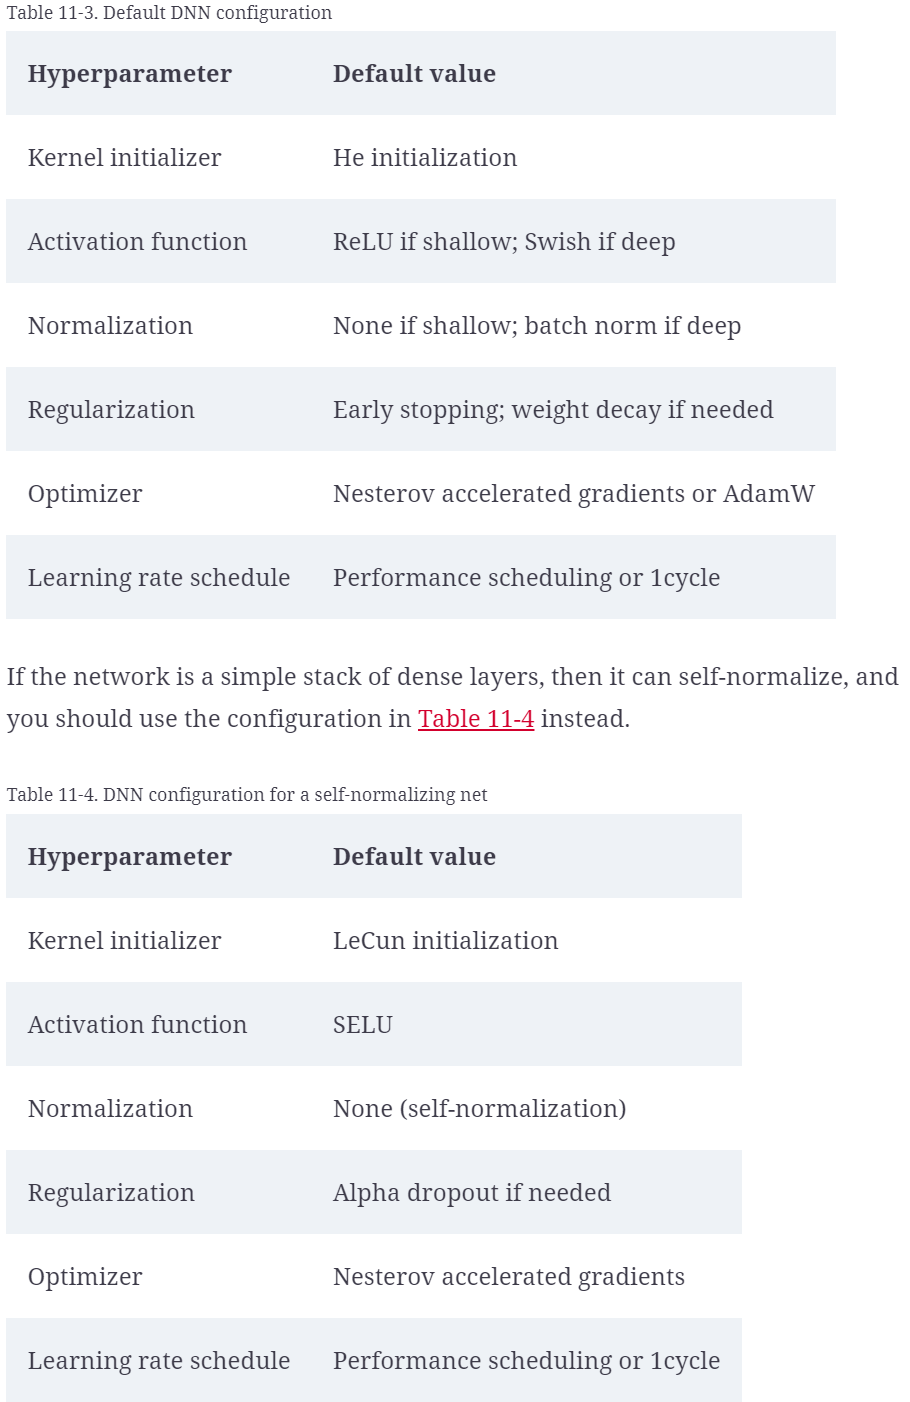
Don’t forget to normalize the input features! You should also try to reuse parts of a pretrained neural network if you can find one that solves a similar problem, or use unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an auxiliary task if you have a lot of labeled data for a similar task.

While the previous guidelines should cover most cases, here are some exceptions:

If you need a sparse model, you can use ℓ1 regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can use the TensorFlow Model Optimization Toolkit. This will break self-normalization, so you should use the default configuration in this case.

If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, use a fast activation function such as ReLU or leaky ReLU, and fold the batch normalization layers into the previous layers after training. Having a sparse model will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits (see “Deploying a Model to a Mobile or Embedded Device”). Again, check out TF-MOT.

If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use MC dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.

# Exercises

## 1. to 7.

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

In [124]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [125]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [126]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [127]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [128]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [129]:
# run the tensorboard: tensorboard --logdir ".\\my_logs"

http://localhost:6006/

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 82s 56ms/step - loss: 5.7078 - accuracy: 0.1551 - val_loss: 2.1760 - val_accuracy: 0.2044
Epoch 2/100
1407/1407 [==============================] - 75s 53ms/step - loss: 2.0910 - accuracy: 0.2361 - val_loss: 2.1075 - val_accuracy: 0.2400
Epoch 3/100
1407/1407 [==============================] - 76s 54ms/step - loss: 1.9675 - accuracy: 0.2820 - val_loss: 1.9971 - val_accuracy: 0.2774
Epoch 4/100
1407/1407 [==============================] - 77s 55ms/step - loss: 1.8895 - accuracy: 0.3125 - val_loss: 1.9850 - val_accuracy: 0.3010
Epoch 5/100
1407/1407 [==============================] - 74s 53ms/step - loss: 1.8245 - accuracy: 0.3373 - val_loss: 1.8964 - val_accuracy: 0.3162
Epoch 6/100
1407/1407 [==============================] - 75s 54ms/step - loss: 1.7732 - accuracy: 0.3594 - val_loss: 1.7503 - val_accuracy: 0.3668
Epoch 7/100
1407/1407 [==============================] - 77s 55ms/step - loss: 1.7270 - accuracy: 0.3722 - val_loss: 1

In [ ]:
model.evaluate(X_valid, y_valid)

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).